# Shifted Beta-Geometric Model with Cohorts and Covariates

The Shifted Beta-Geometric (sBG) model was first introduced in ["How to Project Customer Retention"](https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_jim_07.pdf) by Hardie & Fader in 2007, and is ideal for predicting customer behavior in business cases involving contract renewals or recurring subscriptions. In this notebook we will reproduce the research results with the cohort and covariate functionality of PyMC-Marketing, then proceed to an end-to-end example with EDA and additional predictive methods. 

##### Outstanding Tasks
- [ ] WIP Segment/Cohort clarification for regular/highend
- [ ] expected residual lifetime plots - violin or forest plot
- [ ] expected retention elasticity sentitivity plot - violin or forest plot
- [ ] write-up on the benefits of Bayesian hierarchical models
- [ ] create issue for `xarray.concat` bug (future PR)
- [ ] Dress up original curve plot with additional formatting of cohort example and wrap into function
- [ ] Wrap this curve plot into a function?
- [ ] general cleanup (control yourself)
- [ ] Section headlines (create PR for docs build first)

## Setup Notebook

In [1]:
import pytensor

#set flag to hotfix open c++ errors
pytensor.config.cxx = '/usr/bin/clang++'

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import xarray as xr

from datetime import datetime
from dateutil.relativedelta import relativedelta

from pymc_marketing import clv
import pymc as pm
from pymc_extras.prior import Prior

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams['figure.constrained_layout.use'] = True

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
seed = sum(map(ord, "sBG Model"))
rng = np.random.default_rng(seed)

## Load Data

Data must be aggregrated in the following format for model fitting:

- `customer_id` is an index of unique identifiers for each customer
- `recency` indicates the most recent time period a customer was still active
- `T` is the maximum observed time period for a given cohort
- `cohort` indicates the cohort assignment for each customer

For active customers, `recency` is equal to `T`, and all customers in a given cohort share the same value for `T`. If a customer cancelled their contract and restarted at a later date, a new `customer_id` must be assigned for the restart.

Sample data is available in the PyMC-Marketing repo. To see the code used to generate this data, refer to `generate_sbg_data` in `scripts/clv_data_generation.py`.

In [4]:
cohort_df = pd.read_csv("https://raw.githubusercontent.com/pymc-labs/pymc-marketing/refs/heads/main/data/sbg_cohorts.csv")
cohort_df

customer_id  recency  T   cohort
0               1        1  8  highend
1               2        1  8  highend
2               3        1  8  highend
3               4        1  8  highend
4               5        1  8  highend
...           ...      ... ..      ...
1995         1996        8  8  regular
1996         1997        8  8  regular
1997         1998        8  8  regular
1998         1999        8  8  regular
1999         2000        8  8  regular

[2000 rows x 4 columns]

This dataset was generated from the first 8 time periods in Table 1 of the research paper, which provides survival rates for two types of customers ("Regular" and "Highend") over 13 time periods:

In [121]:
# Data from research paper
research_data = pd.DataFrame(
    {
        "regular": [100.0, 63.1, 46.8, 38.2, 32.6, 28.9, 26.2, 24.1, 22.3, 20.7, 19.4, 18.3, 17.3],
        "highend": [100.0, 86.9, 74.3, 65.3, 59.3, 55.1, 51.7, 49.1, 46.8, 44.5, 42.7, 40.9, 39.4],
    }
)
research_data

regular  highend
0     100.0    100.0
1      63.1     86.9
2      46.8     74.3
3      38.2     65.3
4      32.6     59.3
5      28.9     55.1
6      26.2     51.7
7      24.1     49.1
8      22.3     46.8
9      20.7     44.5
10     19.4     42.7
11     18.3     40.9
12     17.3     39.4

This is also a useful format for model evaluation. In survival analysis parlance, customers with `recency==T` are "right-censored". If we fit a model to the first 8 time periods, we can test predictions on censored data over the remaining 5 periods.

In [6]:
# Utility function to aggregate model fit data for evaluation
def survival_rate_aggregation(customer_df: pd.DataFrame):
    """Aggregate customer-level sBG data into survival rates by cohort over time."""
    # Group by cohort to get total counts
    cohort_totals = customer_df.groupby('cohort')['customer_id'].count()
    cohorts = customer_df["cohort"].unique()
    
    # Create a list to store results for each time period
    results = []
    
    # For each time period from 0 to T (8 in this case)
    for t in range(customer_df['T'].max()):
        row_data = {'T': t}
    
        for cohort in cohorts:
            cohort_data = customer_df[customer_df['cohort'] == cohort]
            total_customers = len(cohort_data)
    
            if t == 0:
                # At time 0, 100% retention
                retention_pct = 100.0
            else:
                # Count customers who survived at least to time t (recency >= t)
                survived = len(cohort_data[cohort_data['recency'] > t])
                retention_pct = (survived / total_customers) * 100
    
            row_data[cohort] = retention_pct
    
        results.append(row_data)

    return pd.DataFrame(results)

# Aggregate model fit data
df_actual = survival_rate_aggregation(cohort_df)

# Assign T column to research data and truncate to 8 periods
research_data["T"] = research_data.index
df_expected = research_data[["T","highend","regular"]].query("T<8").copy()

# Assert aggregated dataset is equivalent to the values in the research paper
pd.testing.assert_frame_equal(df_actual,df_expected)

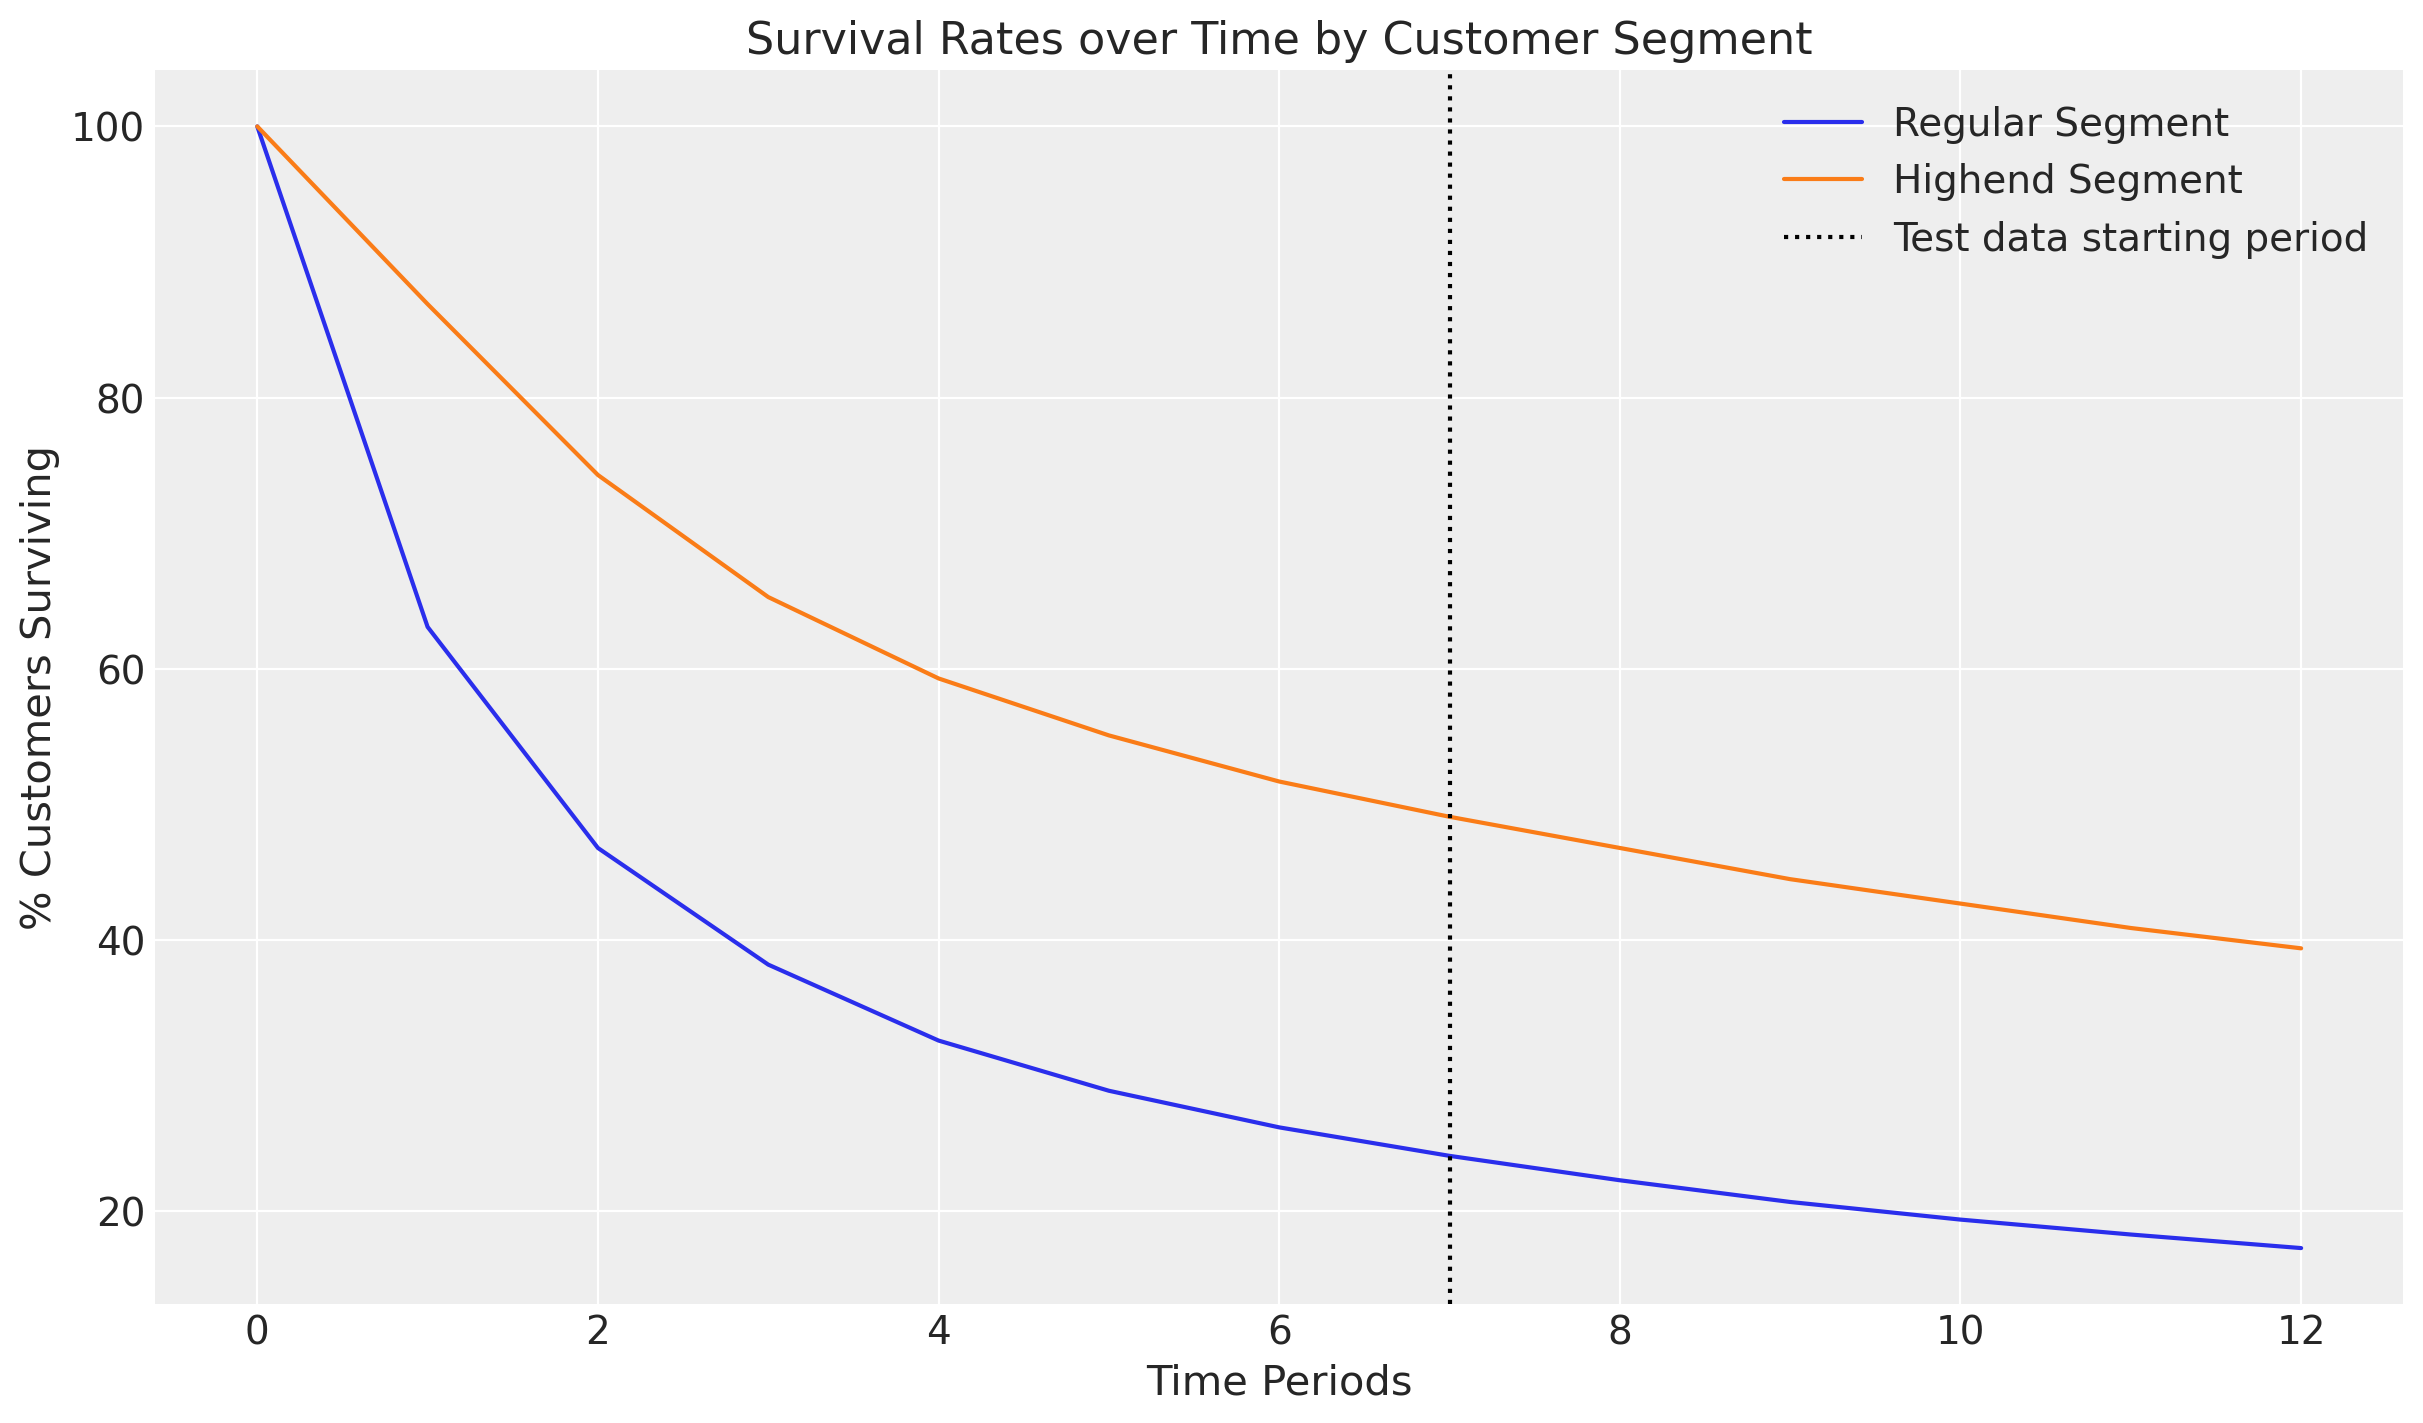

In [123]:
plt.plot(research_data["regular"].values, label="Regular Segment")
plt.plot(research_data["highend"].values, label="Highend Segment")
plt.ylabel("% Customers Surviving")
plt.xlabel("Time Periods")
plt.axvline(7, ls=":", color="k", label="Test data starting period")
plt.legend()
plt.title("Survival Rates over Time by Customer Segment");

Because all customers began their contracts in the same time period, the term "segment" is more appropriate than "cohort". However, we can still model segments with the cohort column in the data. Let's proceed to the modeling step.

# Basic Model Fitting

The sBG model has the following assumptions:

1. Individual customer lifetime durations are characterized by the (shifted) Geometric distribution, with cancellation probability $\theta$.
2. Heterogeneity in $\theta$ follows a Beta distribution with shape parameters $\alpha$ and $\beta$.

If we take the expectation across the distribution of $\theta$, we can derive a likelihood function to estimate parameters $\alpha$ and $\beta$ for the customer population. For more details on the `ShiftedBetaGeometric` mixture distribution, please refer to the [documentation](https://www.pymc-marketing.io/en/latest/api/generated/pymc_marketing.clv.distributions.ShiftedBetaGeometric.html#pymc_marketing.clv.distributions.ShiftedBetaGeometric).

The original frequentist model assumes a single cohort of customers who all started their contracts in the same time period. This requires fitting a separate model for each cohort. However, in PyMC-Marketing we can fit all cohorts in a single hierarchical Bayesian model!

Here are the parameter estimates from the research paper for a sBG model fit with the provided data using Maximum Likelihood Estimation (MLE):

In [8]:
# MLE estimates from the paper
mle_research_parameters = {
    #"cohort": [alpha, beta]
    "regular": [0.704, 1.182],
    "highend": [0.668, 3.806],
}

## Reproduce Research Results with Cohorts

### Model Fitting with MAP

The Bayesian equivalent of a frequentist MLE fit is Maximum a Posteriori (MAP) with "flat" priors. A flat prior can be used when the user is agnostic about the observed data, holding no prior beliefs or assumptions. Since $\alpha$ and $\beta$ must be positive values, let's configure our Bayesian `ShiftedBetaGeoModel` with `HalfFlat` priors:

In [9]:
sbg_map = clv.ShiftedBetaGeoModel(
    data = cohort_df,
    model_config = {
        "alpha": Prior("HalfFlat", dims = "cohort"),
        "beta": Prior("HalfFlat", dims = "cohort"),
    }
)
sbg_map.fit(method="map")
sbg_map.fit_summary()

Output()

alpha[highend]    0.668
alpha[regular]    0.704
beta[highend]     3.806
beta[regular]     1.182
Name: value, dtype: float64

MAP parameter estimates are identical to those in the research. We can also use these parameters recover the latent $\theta$ dropout distributions and recreate Figure 6 in the research paper:

#### Visualize Latent Dropout Distributions

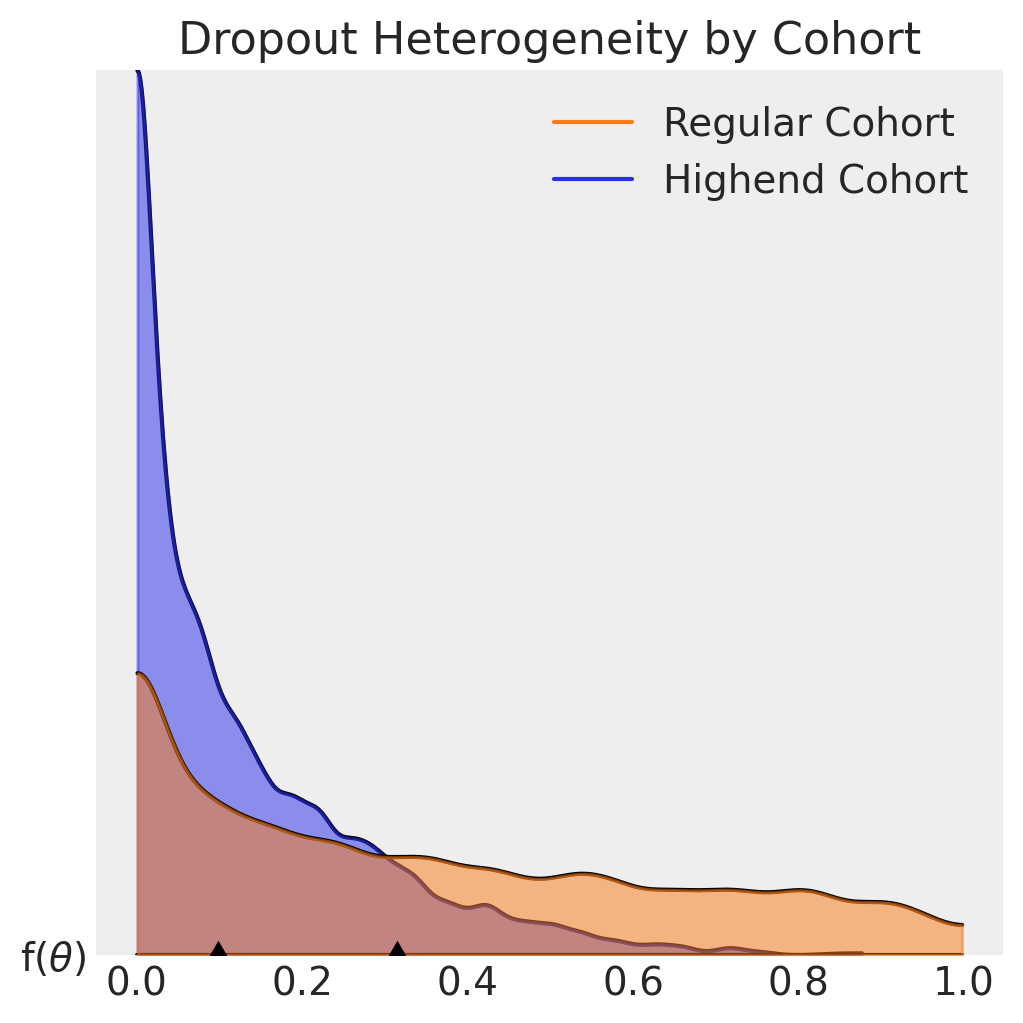

In [107]:
# Extract alpha and beta from fit results
alpha = sbg_map.fit_result["alpha"]
beta = sbg_map.fit_result["beta"]

# Specifiy number of draws from latent theta distributions
n_samples = 4_000

cohorts = alpha.coords['cohort'].values
dropout_samples = np.array([
    rng.beta(
        alpha.sel(cohort=c).values.item(),  # Use .item() to get scalar
        beta.sel(cohort=c).values.item(),   # Use .item() to get scalar
        size=n_samples,
    )
    for c in cohorts
]).T  # Transpose to get (samples, cohorts) shape

# Create xarray DataArray with chain, draw, and cohort dimensions
dropout = xr.DataArray(
    dropout_samples[np.newaxis, :, :],
    dims=("chain", "draw", "cohort"),
    coords={
        "chain": [0],
        "draw": np.arange(n_samples),
        "cohort": cohorts,
    },
    name=r"f($\theta$)",
)

# Convert to InferenceData for plotting in ArviZ 
dropout_idata = az.convert_to_inference_data(dropout)

axes = az.plot_forest(
    [dropout_idata.sel(cohort="highend"),dropout_idata.sel(cohort="regular")],
    model_names = ["Highend Segment","Regular Segment"],
    kind='ridgeplot',
    combined=True,
    colors = ["C0", "C1"],
    hdi_prob=1,
    ridgeplot_alpha=0.5,
    ridgeplot_overlap=1e5,
    ridgeplot_truncate=True,
    ridgeplot_quantiles=[.5],
    figsize=(5,5),
)
axes[0].set_title("Dropout Heterogeneity by Cohort");

It is evident from the plots that dropout probabilities skew lower for customers in the Highend segment, who have a median contract cancellation probability of around 10% at each renewal period. The Regular segment median exceeds 30% in comparison.

Models can be fit very quickly with MAP, but there are important caveats to consider when recreating the frequentist MLE approach:
- Flat priors are slow to converge and can be unstable in practice because no regularization is applied to model parameters during fitting.
- MAP/MLE fits do not provide credibility intervals for predictions.

A big advantage of the Bayesian approach are the prior distributions derived from business domain knowledge and experimentation. With priors we can regularize parameter estimates and speed up model fitting, and with full Bayesian sampling we can infer the posterior distributions, illustrating uncertainty in our parameter estimates as well as enabling prediction intervals.

### Model Fitting with MCMC

The default sampler in PyMC-Marketing is the No-U-Turn Sampler (NUTS), which samples from the posterior by exploring the gradients of the probability space. The default prior configuration for `ShiftedBetaGeoModel` works well for many use cases:

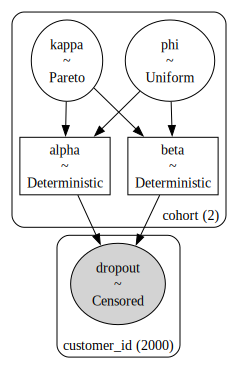

In [124]:
sbg_mcmc = clv.ShiftedBetaGeoModel(data=cohort_df)
sbg_mcmc.build_model() # optional step to view modeling Priors and running prior predictive checks
sbg_mcmc.graphviz()

The default `kappa` and `phi` priors are pooling distributions that improve the speed & reliability of model fits, but can be omitted by specifying a custom `model_config` for `alpha` and `beta`. Note the number of cohorts is also provided and the dropout $\theta$ distribution is censored just like the dataset.

Let's fit a MCMC model and visualize the results:

In [125]:
sbg_mcmc.fit(method='mcmc', random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, kappa]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data

In [126]:
sbg_mcmc.fit_summary(var_names=["alpha","beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[highend]  0.669  0.107   0.493    0.884      0.002    0.002    2785.0   
alpha[regular]  0.702  0.064   0.590    0.821      0.001    0.001    3710.0   
beta[highend]   3.819  0.810   2.380    5.311      0.017    0.014    2261.0   
beta[regular]   1.181  0.149   0.911    1.451      0.003    0.002    2589.0   

                ess_tail  r_hat  
alpha[highend]    3181.0    1.0  
alpha[regular]    3382.0    1.0  
beta[highend]     2148.0    1.0  
beta[regular]     2801.0    1.0

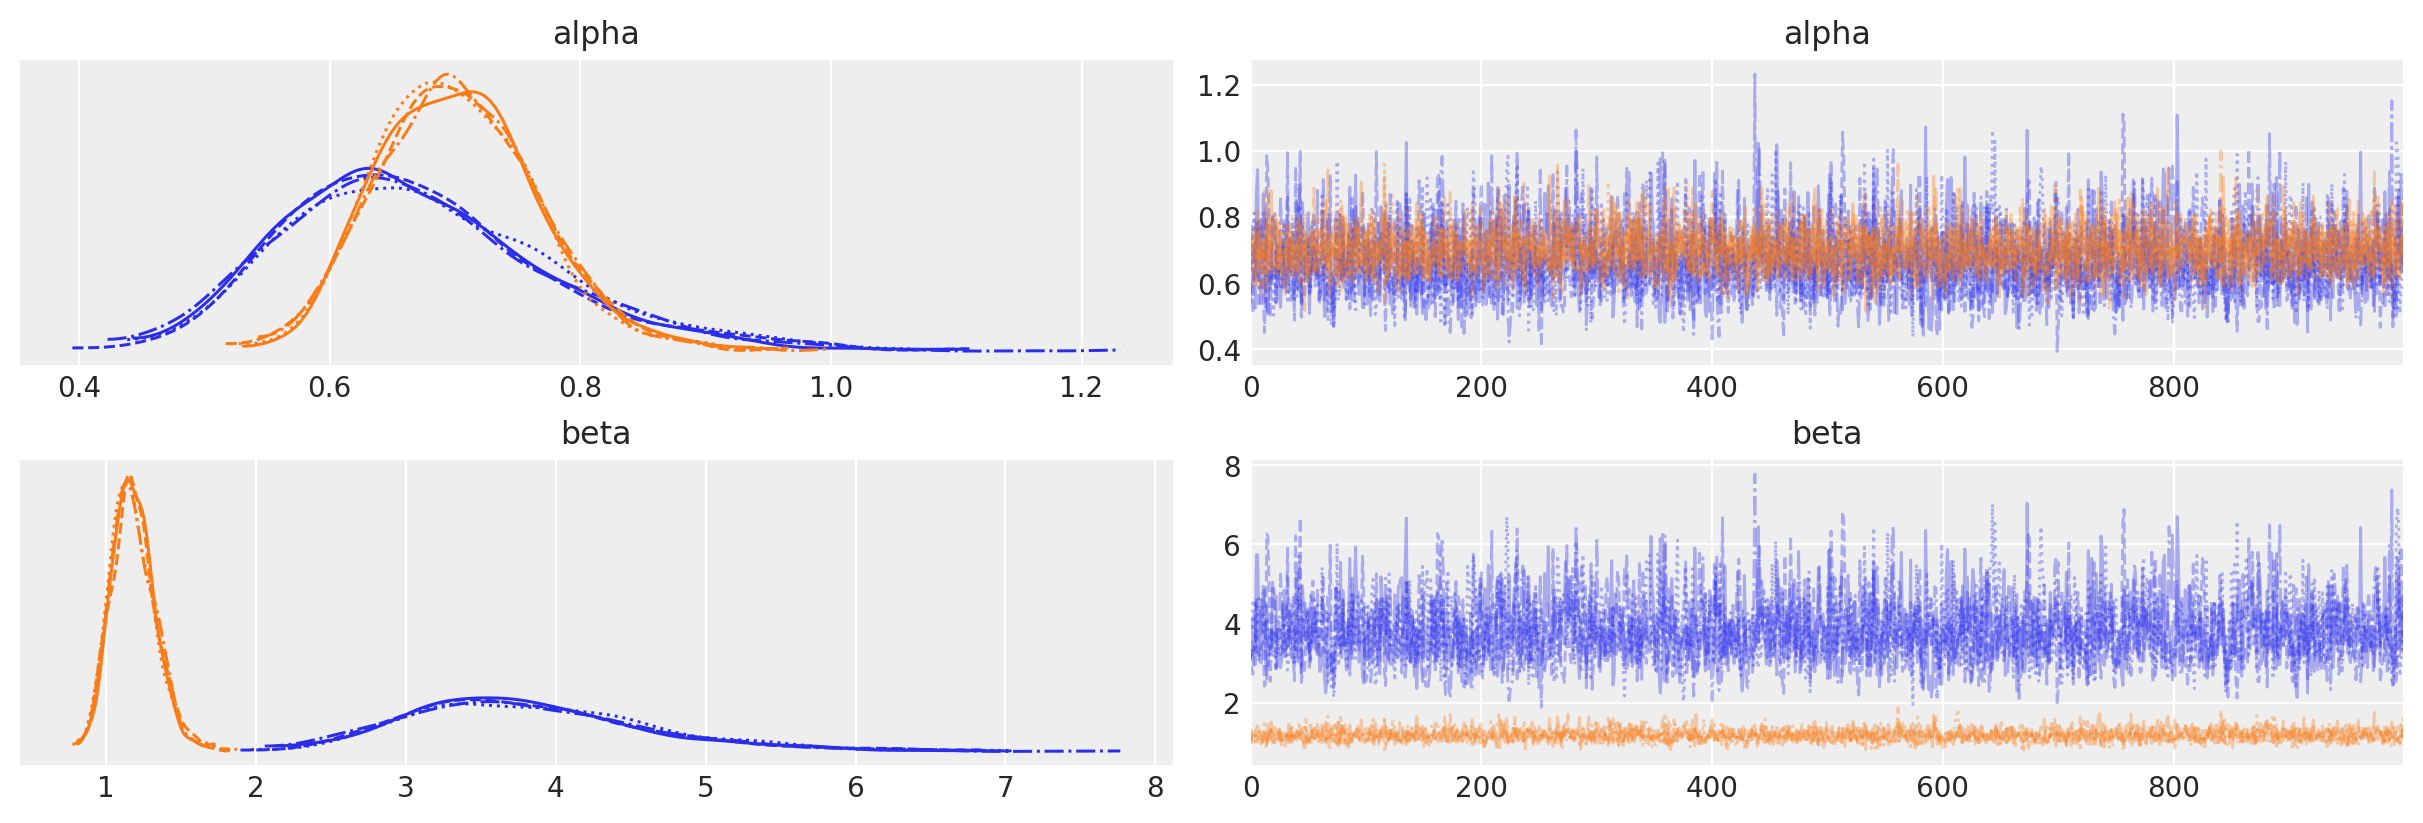

In [127]:
az.plot_trace(sbg_mcmc.idata,var_names=["alpha","beta"]);

Fit summaries and trace plots look good. Let's compare the fitted posterior distributions to the scalar parameter estimates from the research:

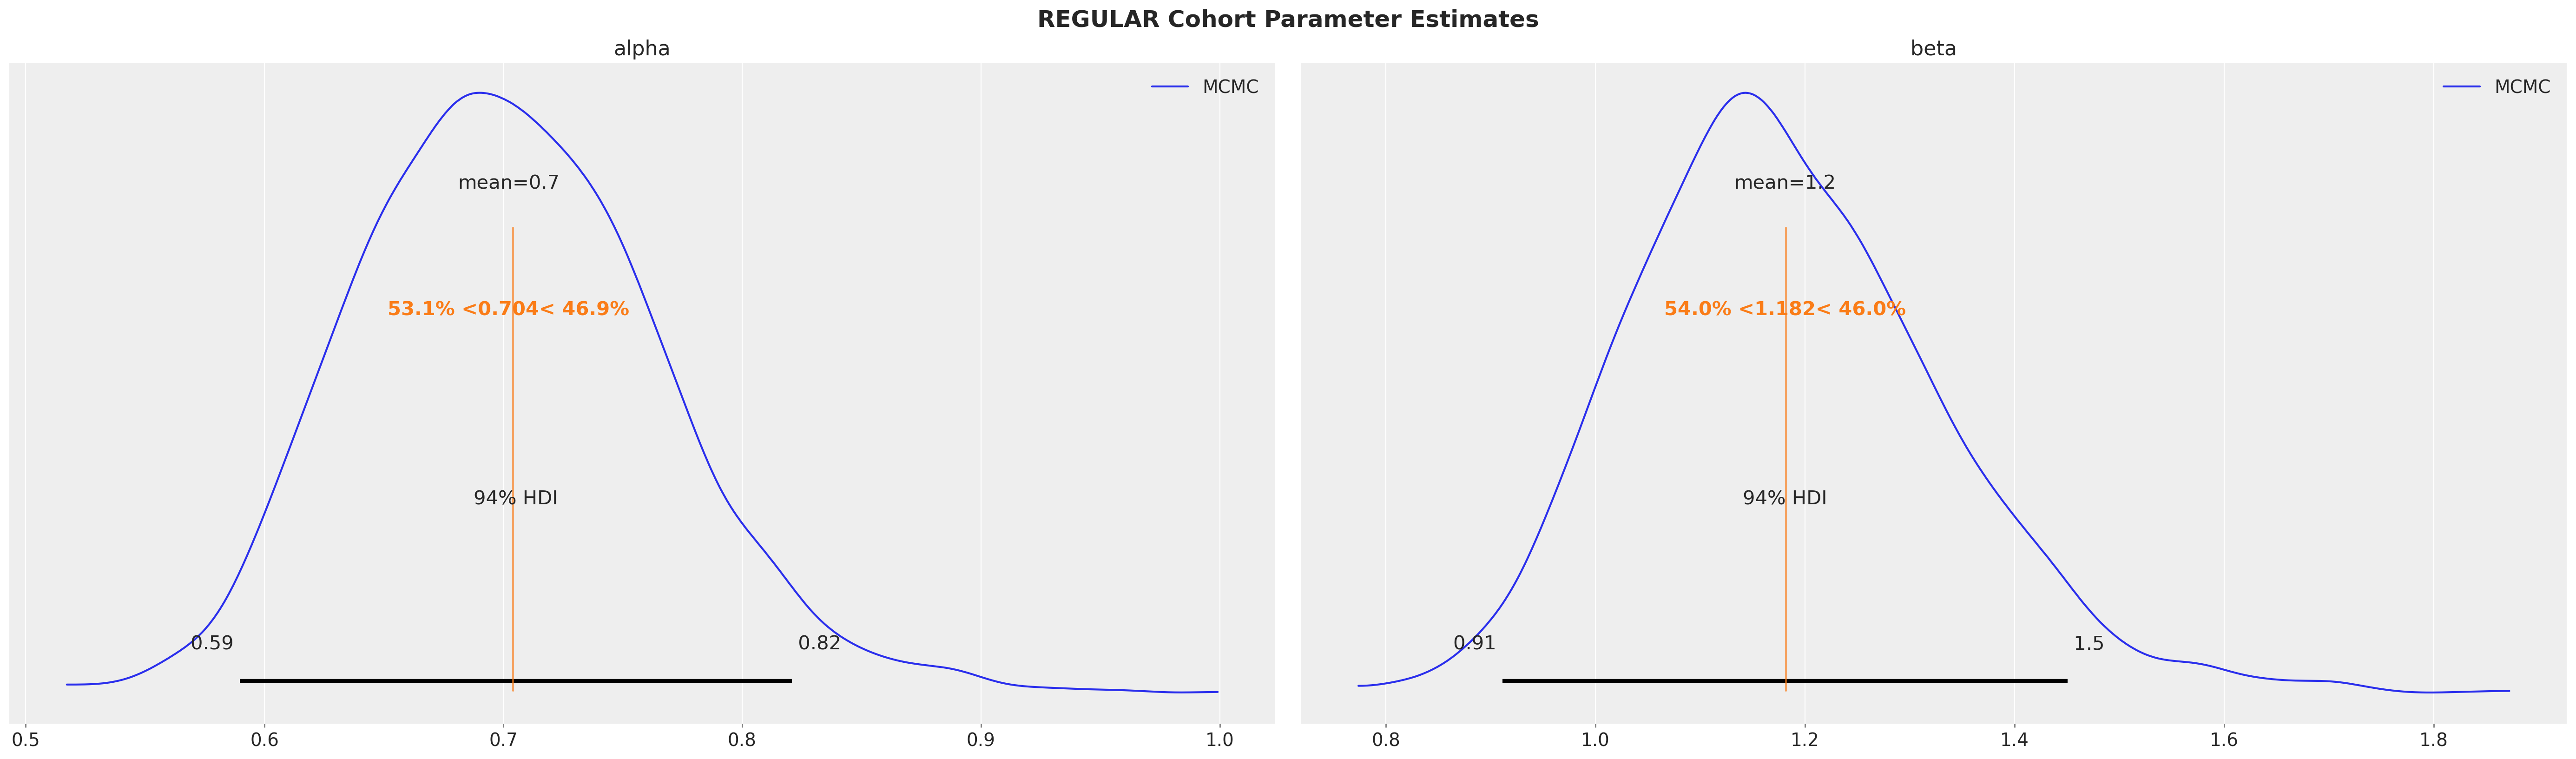

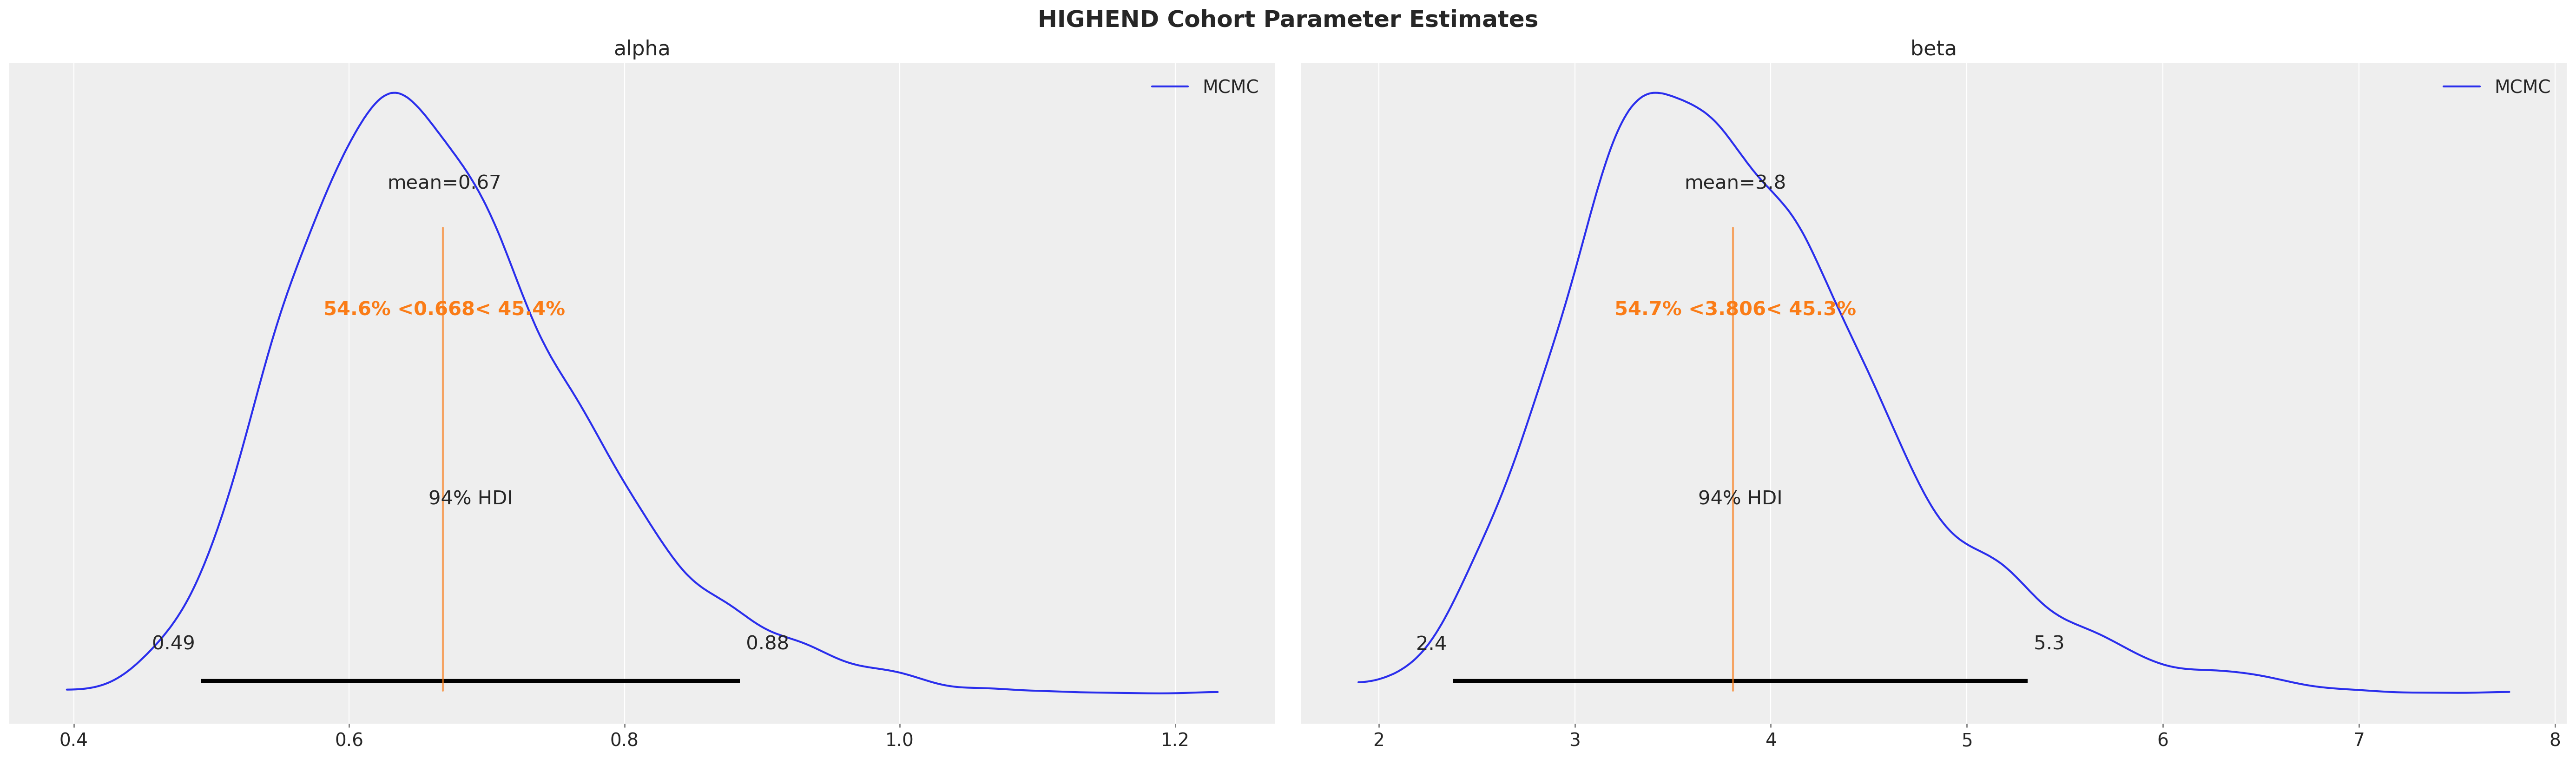

In [128]:
for i, var_name in enumerate(mle_research_parameters.keys()):
    az.plot_posterior(
        sbg_mcmc.idata.sel(cohort=var_name),
        var_names=["alpha", "beta"],
        ref_val=mle_research_parameters[var_name],
        label = "MCMC",
    )
    plt.gcf().suptitle(f"{var_name.upper()} Cohort Parameter Estimates", fontsize=18, fontweight="bold");

Fitted posterior mean values align with the MLE values described in the research paper! MCMC sampling also gives us useful information about the uncertainty of the fits. Note how the mean values are within the 94% HDI intervals but not perfectly centered, indicating the posteriors are assymetrical.

### Model Evaluation with Cohorts

Recall the model was fit to the first $8$ time periods and the remaining $5$ were withheld for testing. The `survival_rate_aggregation()` function can be used to summarize the full dataset in a format equivalent to that of `research_data` to evaluate predictive performance. The aggregated survival data can then be used to create an array of $T$ values for testing:

In [129]:
# Aggregating model fit data to get the training period endpoint.
# (This would normally be ran on the full dataset of train/test data, but that's already aggregated in our case.)
df_fit_eval = survival_rate_aggregation(cohort_df)

# get T values of test and training data
test_T = len(research_data)
train_T = len(df_fit_eval)

# Create T time period array to run predictions on both train and test time periods
T_eval_range = np.arange(train_T * -1, test_T - train_T, 1)
T_eval_range

array([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4])

The `train_T : test_T` range is sufficient for model fit testing, but to get the full context we are also running predictions on past (i.e., negative) time periods.

#### Survival Function
The sBG [*survival function*](https://www.pymc-marketing.io/en/stable/api/generated/classmethods/pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_probability_alive.html#pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_probability_alive) is the probability customers within a given cohort are still active after a specified time period. It is called with `model.expected_probability_alive()`:

In [130]:
expected_survival_rates = xr.concat(
    objs=[
        sbg_mcmc.expected_probability_alive(
            future_t=T,
        )
        for T in T_eval_range
    ],
    dim="T",
).transpose(..., "T")

Plotting credibility intervals for survival rates against the observed data:

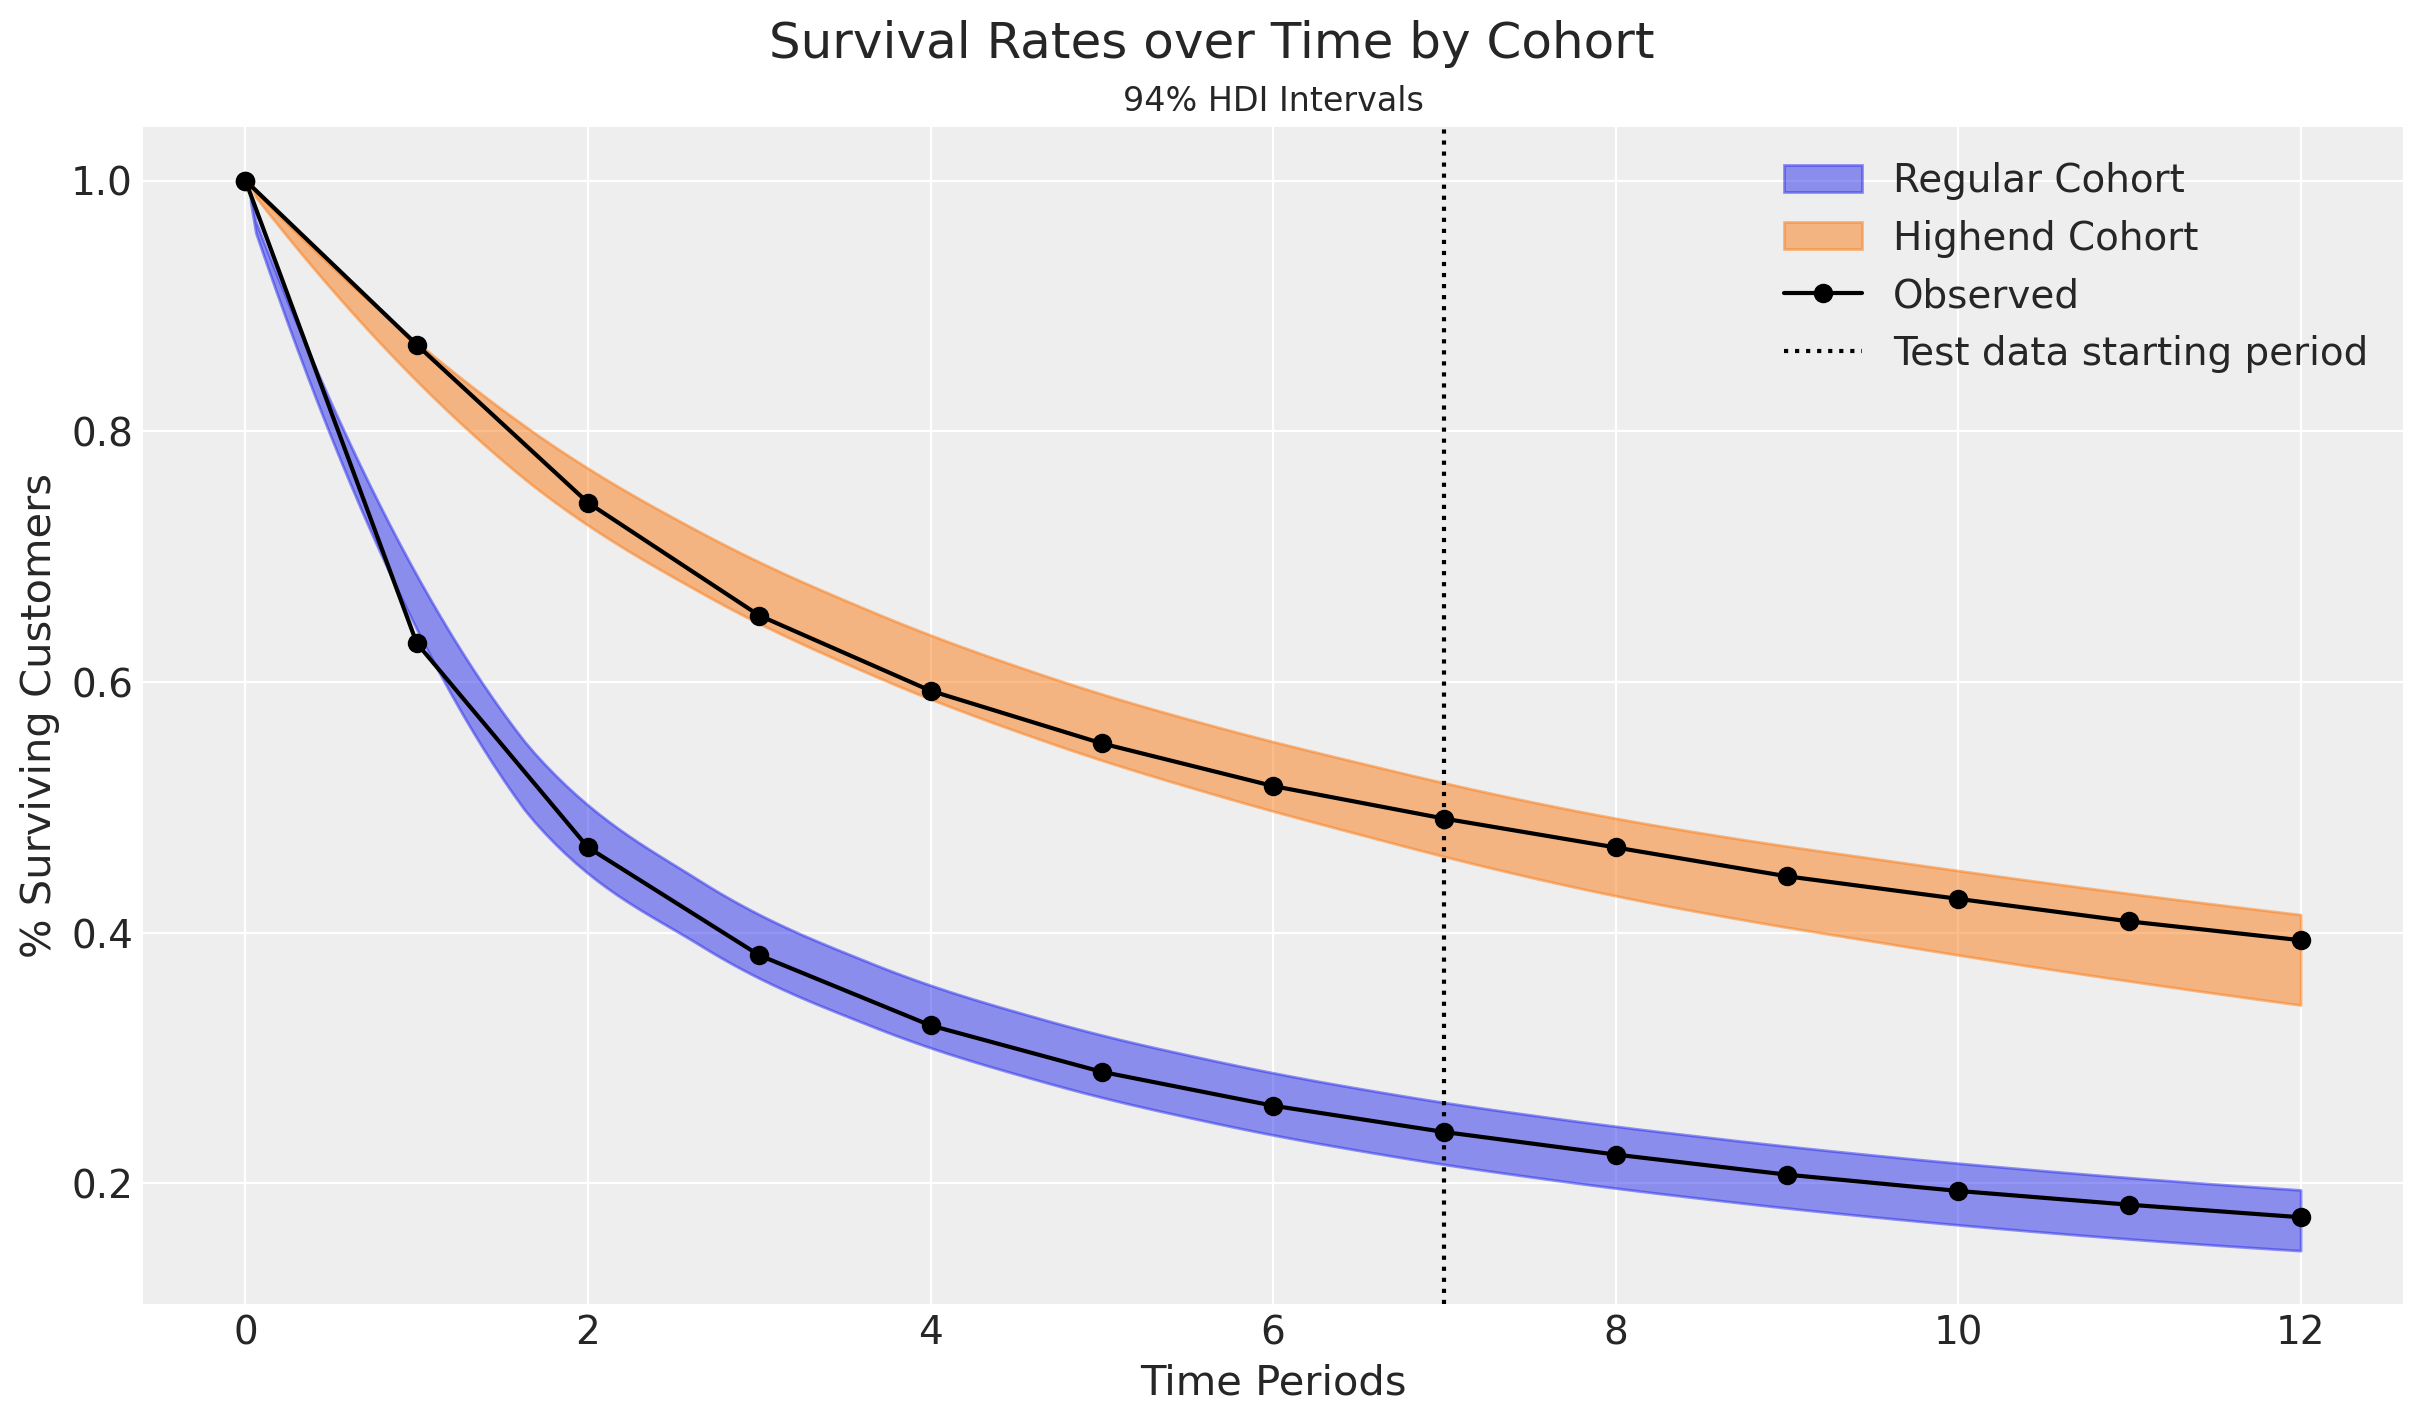

In [134]:
az.plot_hdi(
        range(test_T),
        expected_survival_rates.sel(cohort="regular").mean("cohort"),
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.5, "label": "Regular Cohort"},
    )
az.plot_hdi(
        range(test_T),
        expected_survival_rates.sel(cohort="highend").mean("cohort"),
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.5, "label": "Highend Cohort"},
    )
plt.plot(range(test_T), research_data["highend"]/100, marker='o', color="k", label="Observed")
plt.plot(range(test_T), research_data["regular"]/100, marker='o', color="k")
plt.ylabel("% Surviving Customers")
plt.xlabel("Time Periods")
plt.axvline(7, ls=":", color="k", label="Test data starting period")
plt.legend()
plt.suptitle("Survival Rates over Time by Cohort",fontsize=18)
plt.title("94% HDI Intervals",fontsize=12);

Observed survival rates fall well within the 94% credibility intervals!

#### Retention Rate

We can also predict the [*retention rate*](https://www.pymc-marketing.io/en/stable/api/generated/classmethods/pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_retention_rate.html#pymc_marketing.clv.models.shifted_beta_geo.ShiftedBetaGeoModel.expected_retention_rate) by cohort, which is defined as the proportion of customers active in period $T-1$ who are still active in period $T$:

In [135]:
expected_retention_rates = xr.concat(
    objs=[
        sbg_mcmc.expected_retention_rate(
            future_t=T,
        )
        for T in T_eval_range[1:] # omit starting time period (see below)
    ],
    dim="T",
).transpose(..., "T")

# Calculate observed retention rates by cohort.
# Initial start period does not have a retention rate, so retention array is 1 time period shorter than observed.
retention_rate_highend_obs = research_data["highend"][1:].values / research_data["highend"][:-1].values
retention_rate_regular_obs = research_data["regular"][1:].values / research_data["regular"][:-1].values

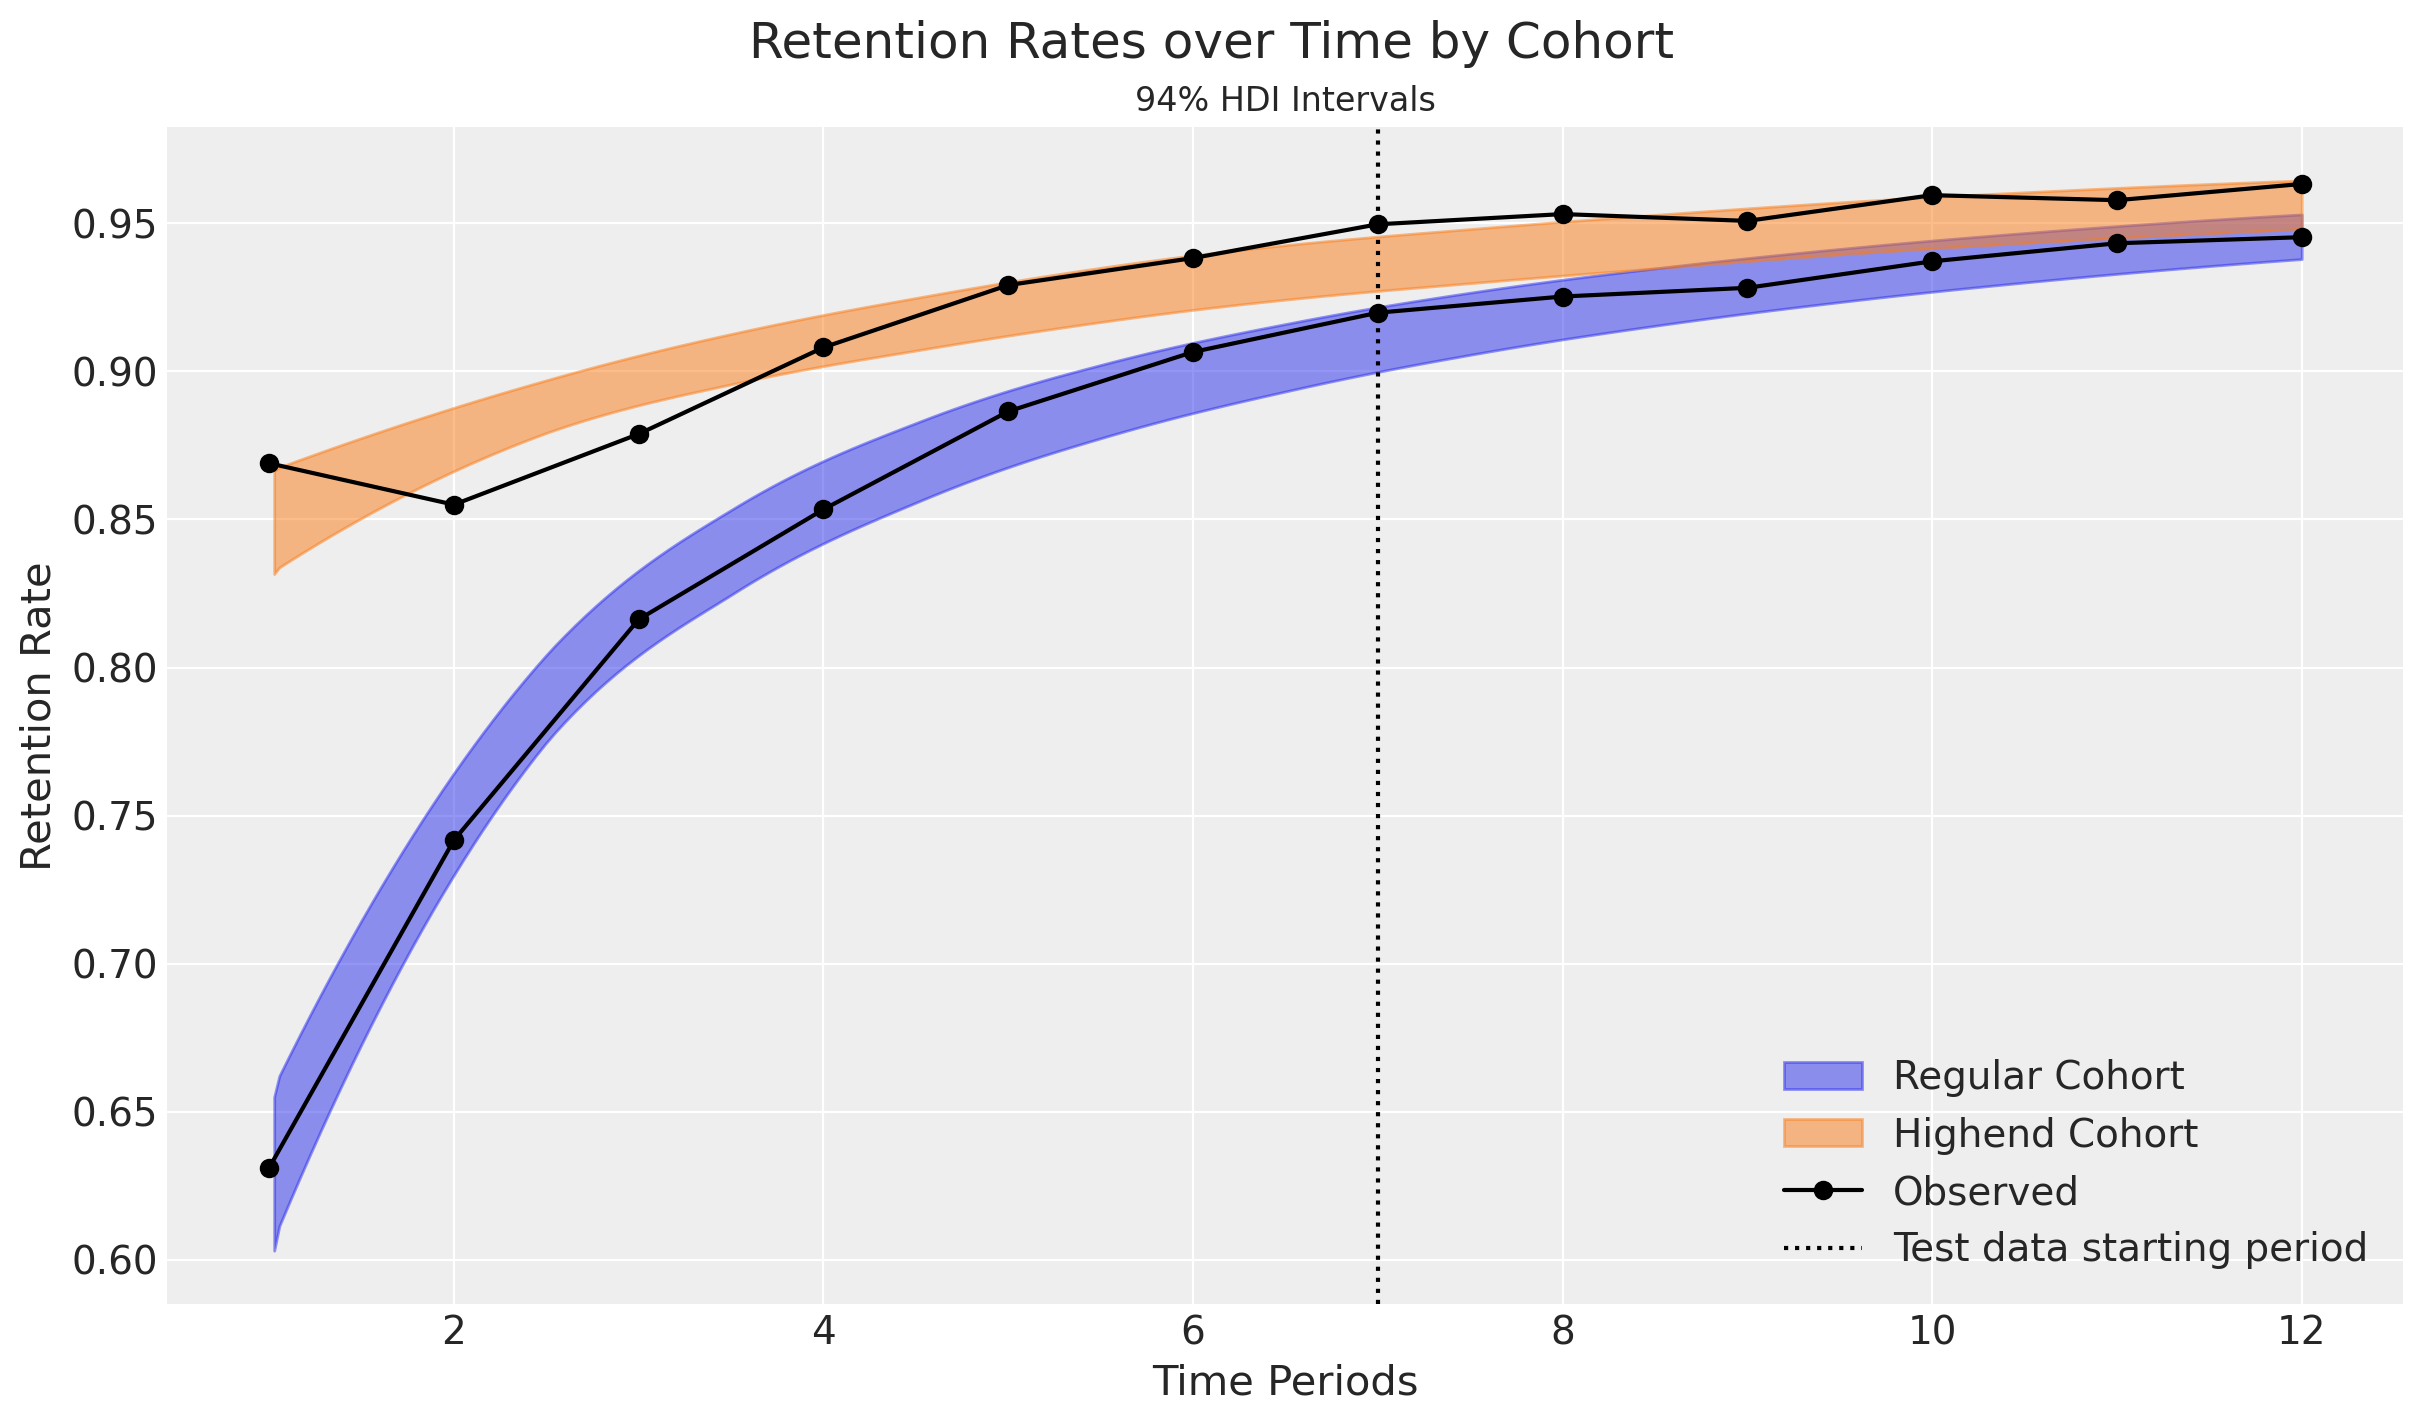

In [136]:
az.plot_hdi(
        range(1, test_T),
        expected_retention_rates.sel(cohort="regular").mean("cohort"),
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.5, "label": "Regular Cohort"},
    )
az.plot_hdi(
        range(1, test_T),
        expected_retention_rates.sel(cohort="highend").mean("cohort"),
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.5, "label": "Highend Cohort"},
    )
plt.plot(range(1, test_T), retention_rate_highend_obs, marker='o',color="k", label="Observed")
plt.plot(range(1, test_T), retention_rate_regular_obs, marker='o', color="k")
plt.ylabel("Retention Rate")
plt.xlabel("Time Periods")
plt.axvline(7, ls=":", color="k", label="Test data starting period")
plt.legend()
plt.suptitle("Retention Rates over Time by Cohort",fontsize=18)
plt.title("94% HDI Intervals",fontsize=12);

Retention rate predictions fall within the 94% credibility intervals for the Regular Cohort. The Highend Cohort is more erratic but improves over time.

The plots also highlight an interesting implication from the model: *Retention rates increase over time as higher-risk customers become inactive,* an outcome of customer heterogeneity. Heterogeneity within cohorts can be modeled further with the addition of covariates.

## Reproduce Research Results with Covariates

Since we are dealing with segments rather than cohorts, we can demarcate segments with a simple binary covariate since they start in the same time period. Let's modify the fit data to do so:

In [137]:
# Create a covariate column to identify highend customers
cohort_df["highend_customer"] = np.where(cohort_df["cohort"] == "highend", 1, 0)
# Update cohort column to a single "population" cohort
covariate_df = cohort_df.assign(cohort="population")
covariate_df

customer_id  recency  T      cohort  highend_customer
0               1        1  8  population                 1
1               2        1  8  population                 1
2               3        1  8  population                 1
3               4        1  8  population                 1
4               5        1  8  population                 1
...           ...      ... ..         ...               ...
1995         1996        8  8  population                 0
1996         1997        8  8  population                 0
1997         1998        8  8  population                 0
1998         1999        8  8  population                 0
1999         2000        8  8  population                 0

[2000 rows x 5 columns]

Recall $\alpha$ and $\beta$ represent the shape parameters of the latent Beta dropout distribution for each cohort. To include time-invariant covariates in our model, we simply modify these parameters as follows:

$$\alpha = \alpha_0e^{-\gamma_1z}$$
$$\beta = \beta_0e^{-\gamma_2z}$$

Where $\gamma_1$ and $\gamma_2$ are coefficients capturing the effects of the $z$ covariate arrays for each customer.

These additional parameters are automatically created when covariate column names are specified in the `model_config`:

In [138]:
sbg_covar = clv.ShiftedBetaGeoModel(
    data=covariate_df,
        model_config = {
        "dropout_covariate_cols": ["highend_customer"],
    }
)
sbg_covar.build_model()
sbg_covar

Shifted Beta-Geometric
                      phi ~ Uniform(0, 1)
                    kappa ~ Pareto(1, 1)
dropout_coefficient_alpha ~ Normal(0, 1)
 dropout_coefficient_beta ~ Normal(0, 1)
              alpha_scale ~ Deterministic(f(kappa, phi))
               beta_scale ~ Deterministic(f(kappa, phi))
                    alpha ~ Deterministic(f(dropout_coefficient_alpha, kappa, phi))
                     beta ~ Deterministic(f(dropout_coefficient_beta, kappa, phi))
                  dropout ~ Censored(ShiftedBetaGeometric(alpha, beta), -inf, <constant>)

### Model Fitting with DEMZ

MCMC model fits require more time with covariates compared to cohorts. A gradient-free sampler like Adaptive Differential Evolution Metropolis ([`DEMetropolisZ`](https://www.pymc.io/projects/docs/en/v5.6.1/api/generated/pymc.DEMetropolisZ.html)) will converge in far less time, but requires more samples.

In [146]:
sbg_covar.fit(fit_method='demz', tune=2000, draws=3000, random_seed=rng) # 'demz' requires more tune/draws for convergence

# After fitting, remove redundant samples to reduce model size and increase predictive method processing speed
sbg_covar = sbg_covar.thin_fit_result(keep_every=3)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [phi, kappa, dropout_coefficient_alpha, dropout_coefficient_beta]


Output()

Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 3 seconds.


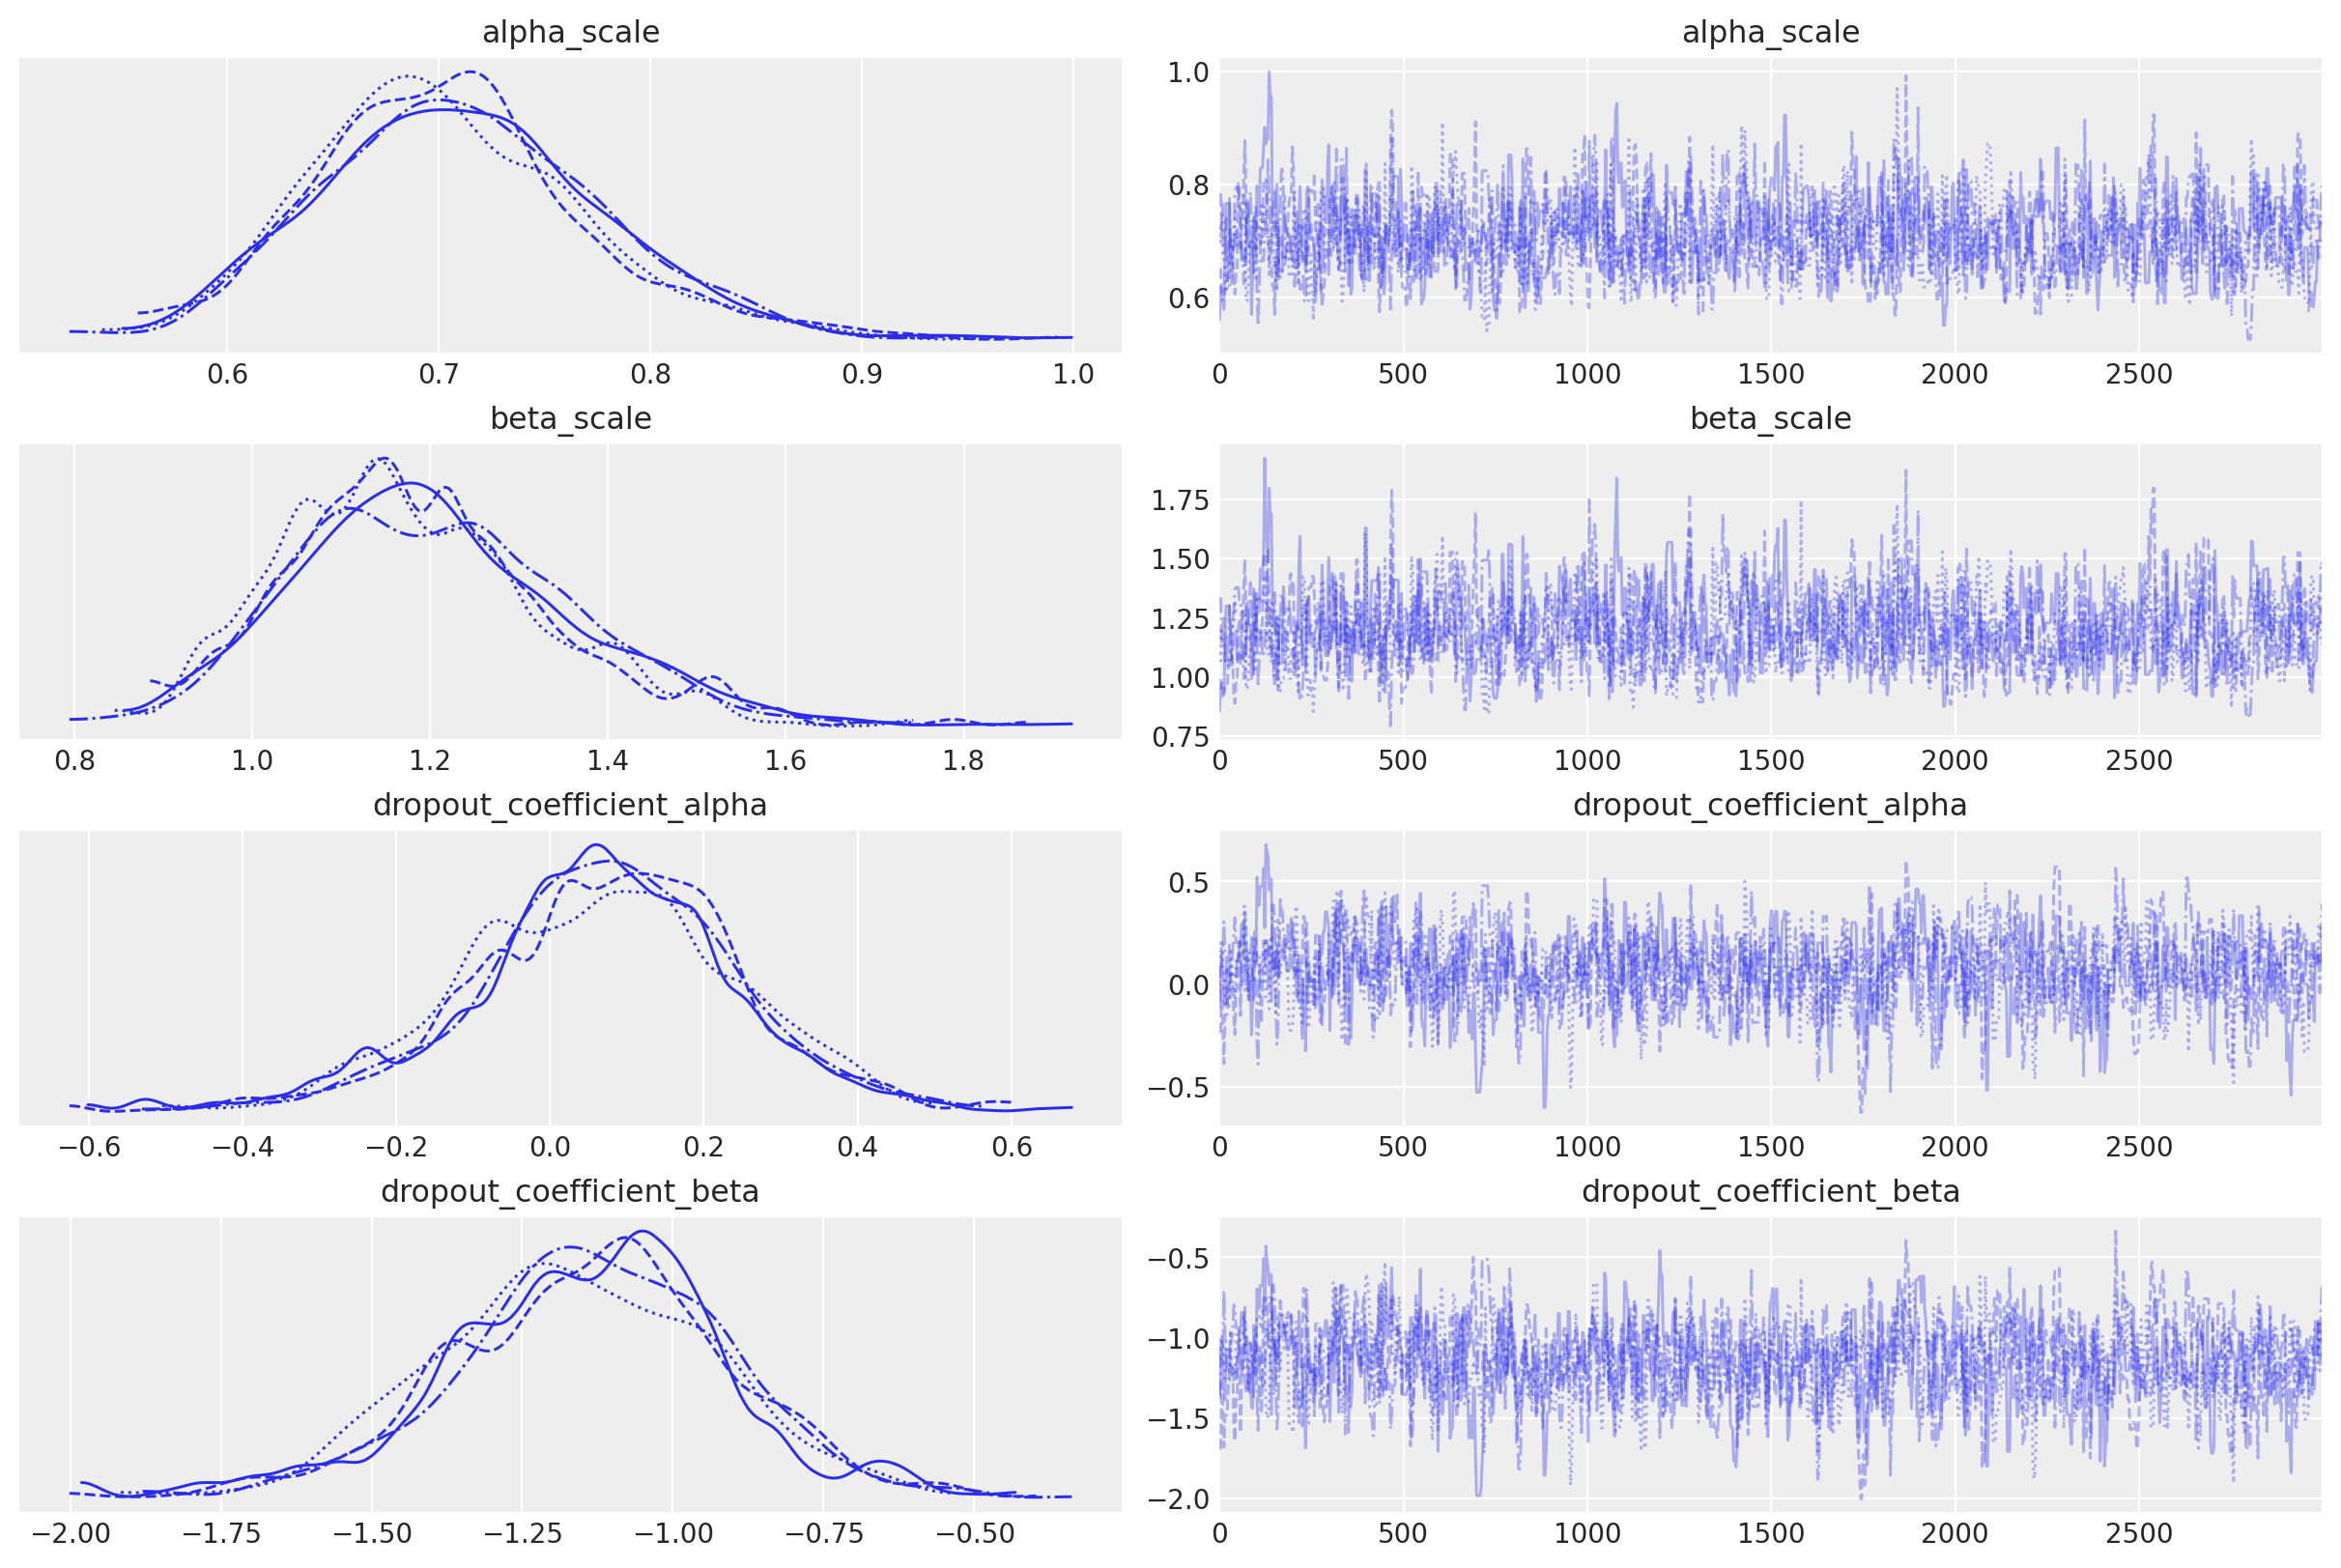

In [149]:
az.plot_trace(sbg_covar.idata,var_names=["alpha_scale","beta_scale", "dropout_coefficient_alpha", "dropout_coefficient_beta"]);

`alpha_scale` and `beta_scale` are baseline posteriors for each cohort, and the `dropout_coefficient` posteriors represent covariate effects across the entire customer population.

In this simple example with a single cohort ("population") and binary covariate variable ("highend customer"), we can see the mean impact of this covariate on `alpha` is near-zero, but the impact on `beta` is significantly higher.

Recall the mean of the Beta distribution:

$$E(\theta) = \frac{\alpha}{\alpha + \beta}$$

The negatively-valued posterior indicates `beta` will *increase* for each highend customer, and reduce the dropout expectation.

Cohort and covariate parameters are broadcasted together to create `alpha` and `beta` parameter pairs for every `customer id`:

In [153]:
sbg_covar.fit_summary(var_names=["alpha","beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[1]    0.667  0.105   0.492    0.861      0.004    0.003     733.0   
alpha[2]    0.667  0.105   0.492    0.861      0.004    0.003     733.0   
alpha[3]    0.667  0.105   0.492    0.861      0.004    0.003     733.0   
alpha[4]    0.667  0.105   0.492    0.861      0.004    0.003     733.0   
alpha[5]    0.667  0.105   0.492    0.861      0.004    0.003     733.0   
...           ...    ...     ...      ...        ...      ...       ...   
beta[1996]  1.192  0.151   0.920    1.476      0.005    0.003     844.0   
beta[1997]  1.192  0.151   0.920    1.476      0.005    0.003     844.0   
beta[1998]  1.192  0.151   0.920    1.476      0.005    0.003     844.0   
beta[1999]  1.192  0.151   0.920    1.476      0.005    0.003     844.0   
beta[2000]  1.192  0.151   0.920    1.476      0.005    0.003     844.0   

            ess_tail  r_hat  
alpha[1]      1321.0    1.0  
alpha[2]      1321.0    1.0  
alpha[3]      1321.0    1.0  
alpha[4]      1321.0    1.0  
alpha[5]      1321.0    1.0  
...              ...    ...  
beta[1996]    1251.0    1.0  
beta[1997]    1251.0    1.0  
beta[1998]    1251.0    1.0  
beta[1999]    1251.0    1.0  
beta[2000]    1251.0    1.0  

[4000 rows x 9 columns]

### Reproduce Research with Covariates
To compare covariate `alpha` and `beta` estimates to the original research, we can use `customer_id` to extract parameters for known highend and regular customers:

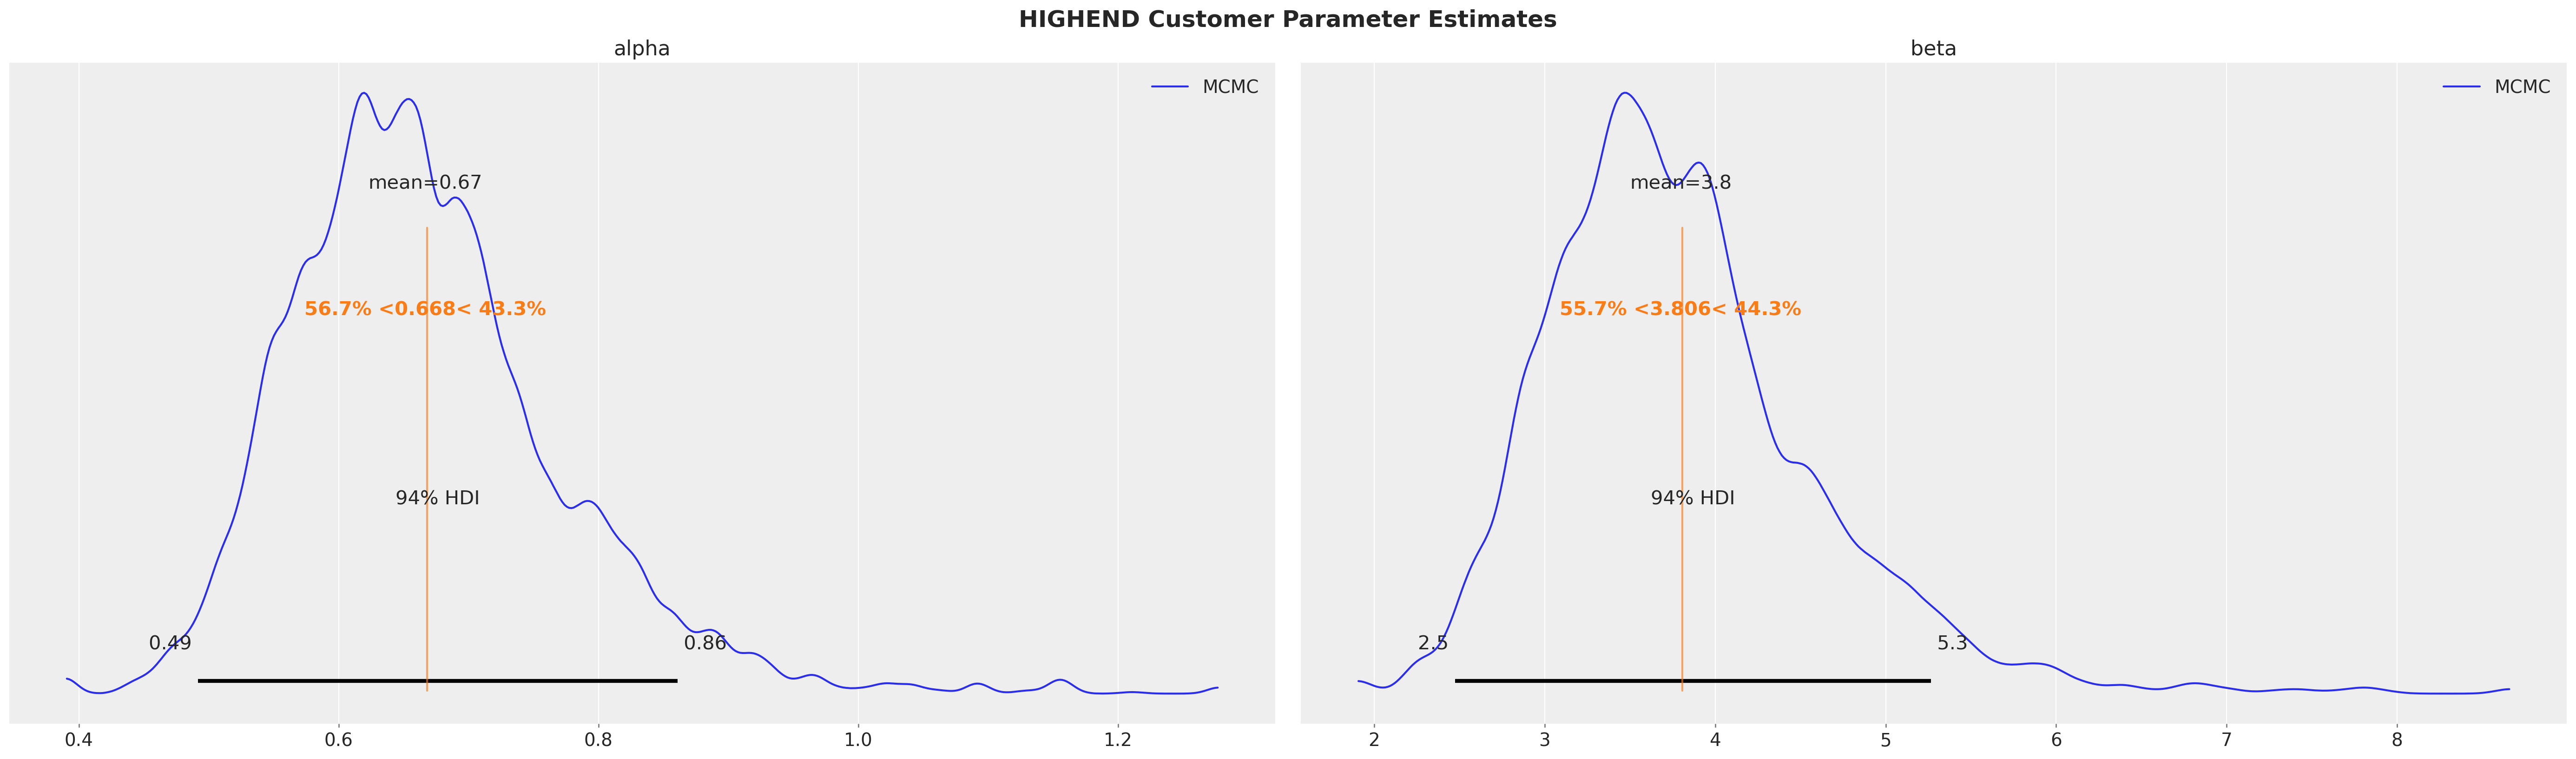

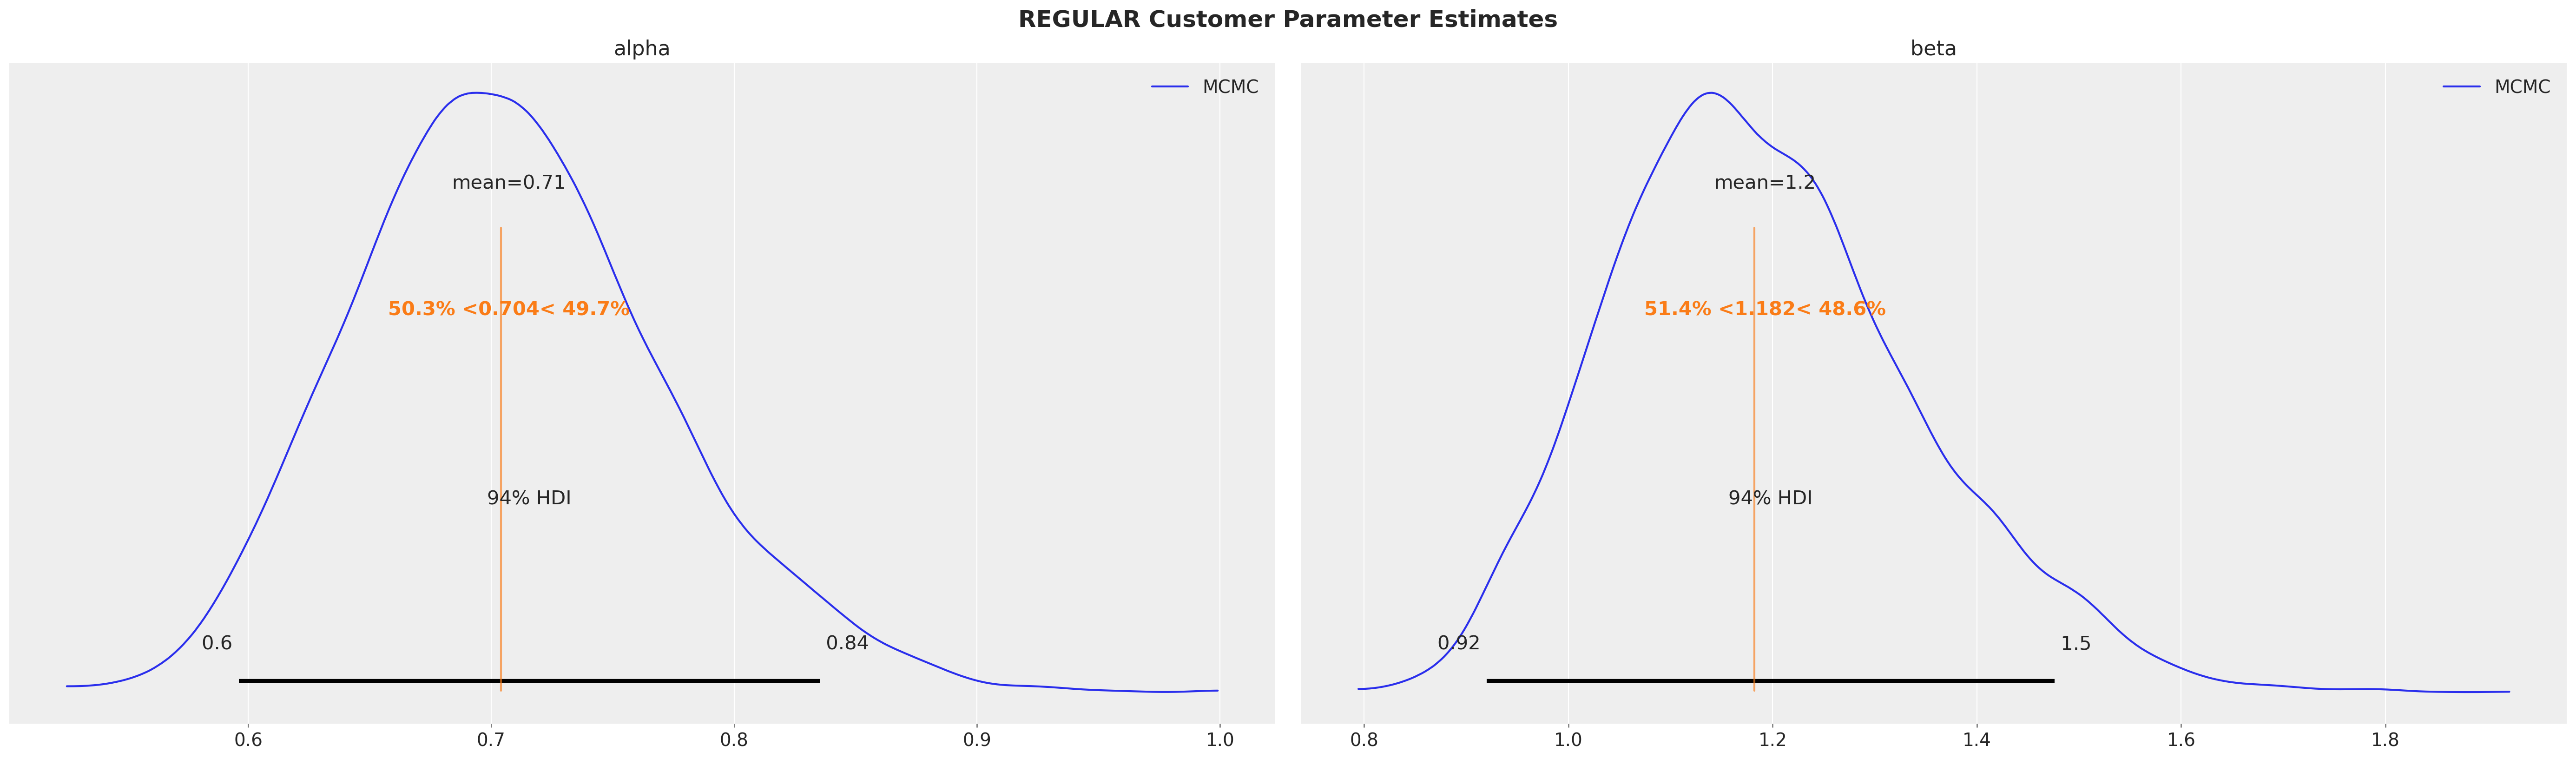

In [154]:
covariate_customer_ids = {
    "highend": 1,
    "regular": 2000,
}

for cohort, customer_id in covariate_customer_ids.items():
    az.plot_posterior(
        sbg_covar.idata.sel(customer_id=customer_id),
        var_names=["alpha", "beta"],
        ref_val=mle_research_parameters[cohort],
        label = "MCMC",
    )
    plt.gcf().suptitle(f"{cohort.upper()} Customer Parameter Estimates", fontsize=18, fontweight="bold");

Parameter estimates are identical regardless of the customer being identified by cohort or covariate! Survival predictions are identical as well:

In [155]:
# If running predictions on out-of-sample data, or a subset of the fit data,
# remember to exclude inactive customers:
active_covariate_customers = covariate_df.query("recency==T").copy()

highend_active = active_covariate_customers.query("highend_customer==1").copy()
regular_active = active_covariate_customers.query("highend_customer==0").copy()

# run survival predictions seperately for regular and highend customers
expected_survival_rates_hi = xr.concat(
    objs=[
        sbg_covar.expected_probability_alive(
            data=highend_active,
            future_t=T,
        )
        for T in T_eval_range
    ],
    dim="T",
).transpose(..., "T")

expected_survival_rates_reg = xr.concat(
    objs=[
        sbg_covar.expected_probability_alive(
            data=regular_active,
            future_t=T,
        )
        for T in T_eval_range
    ],
    dim="T",
).transpose(..., "T")

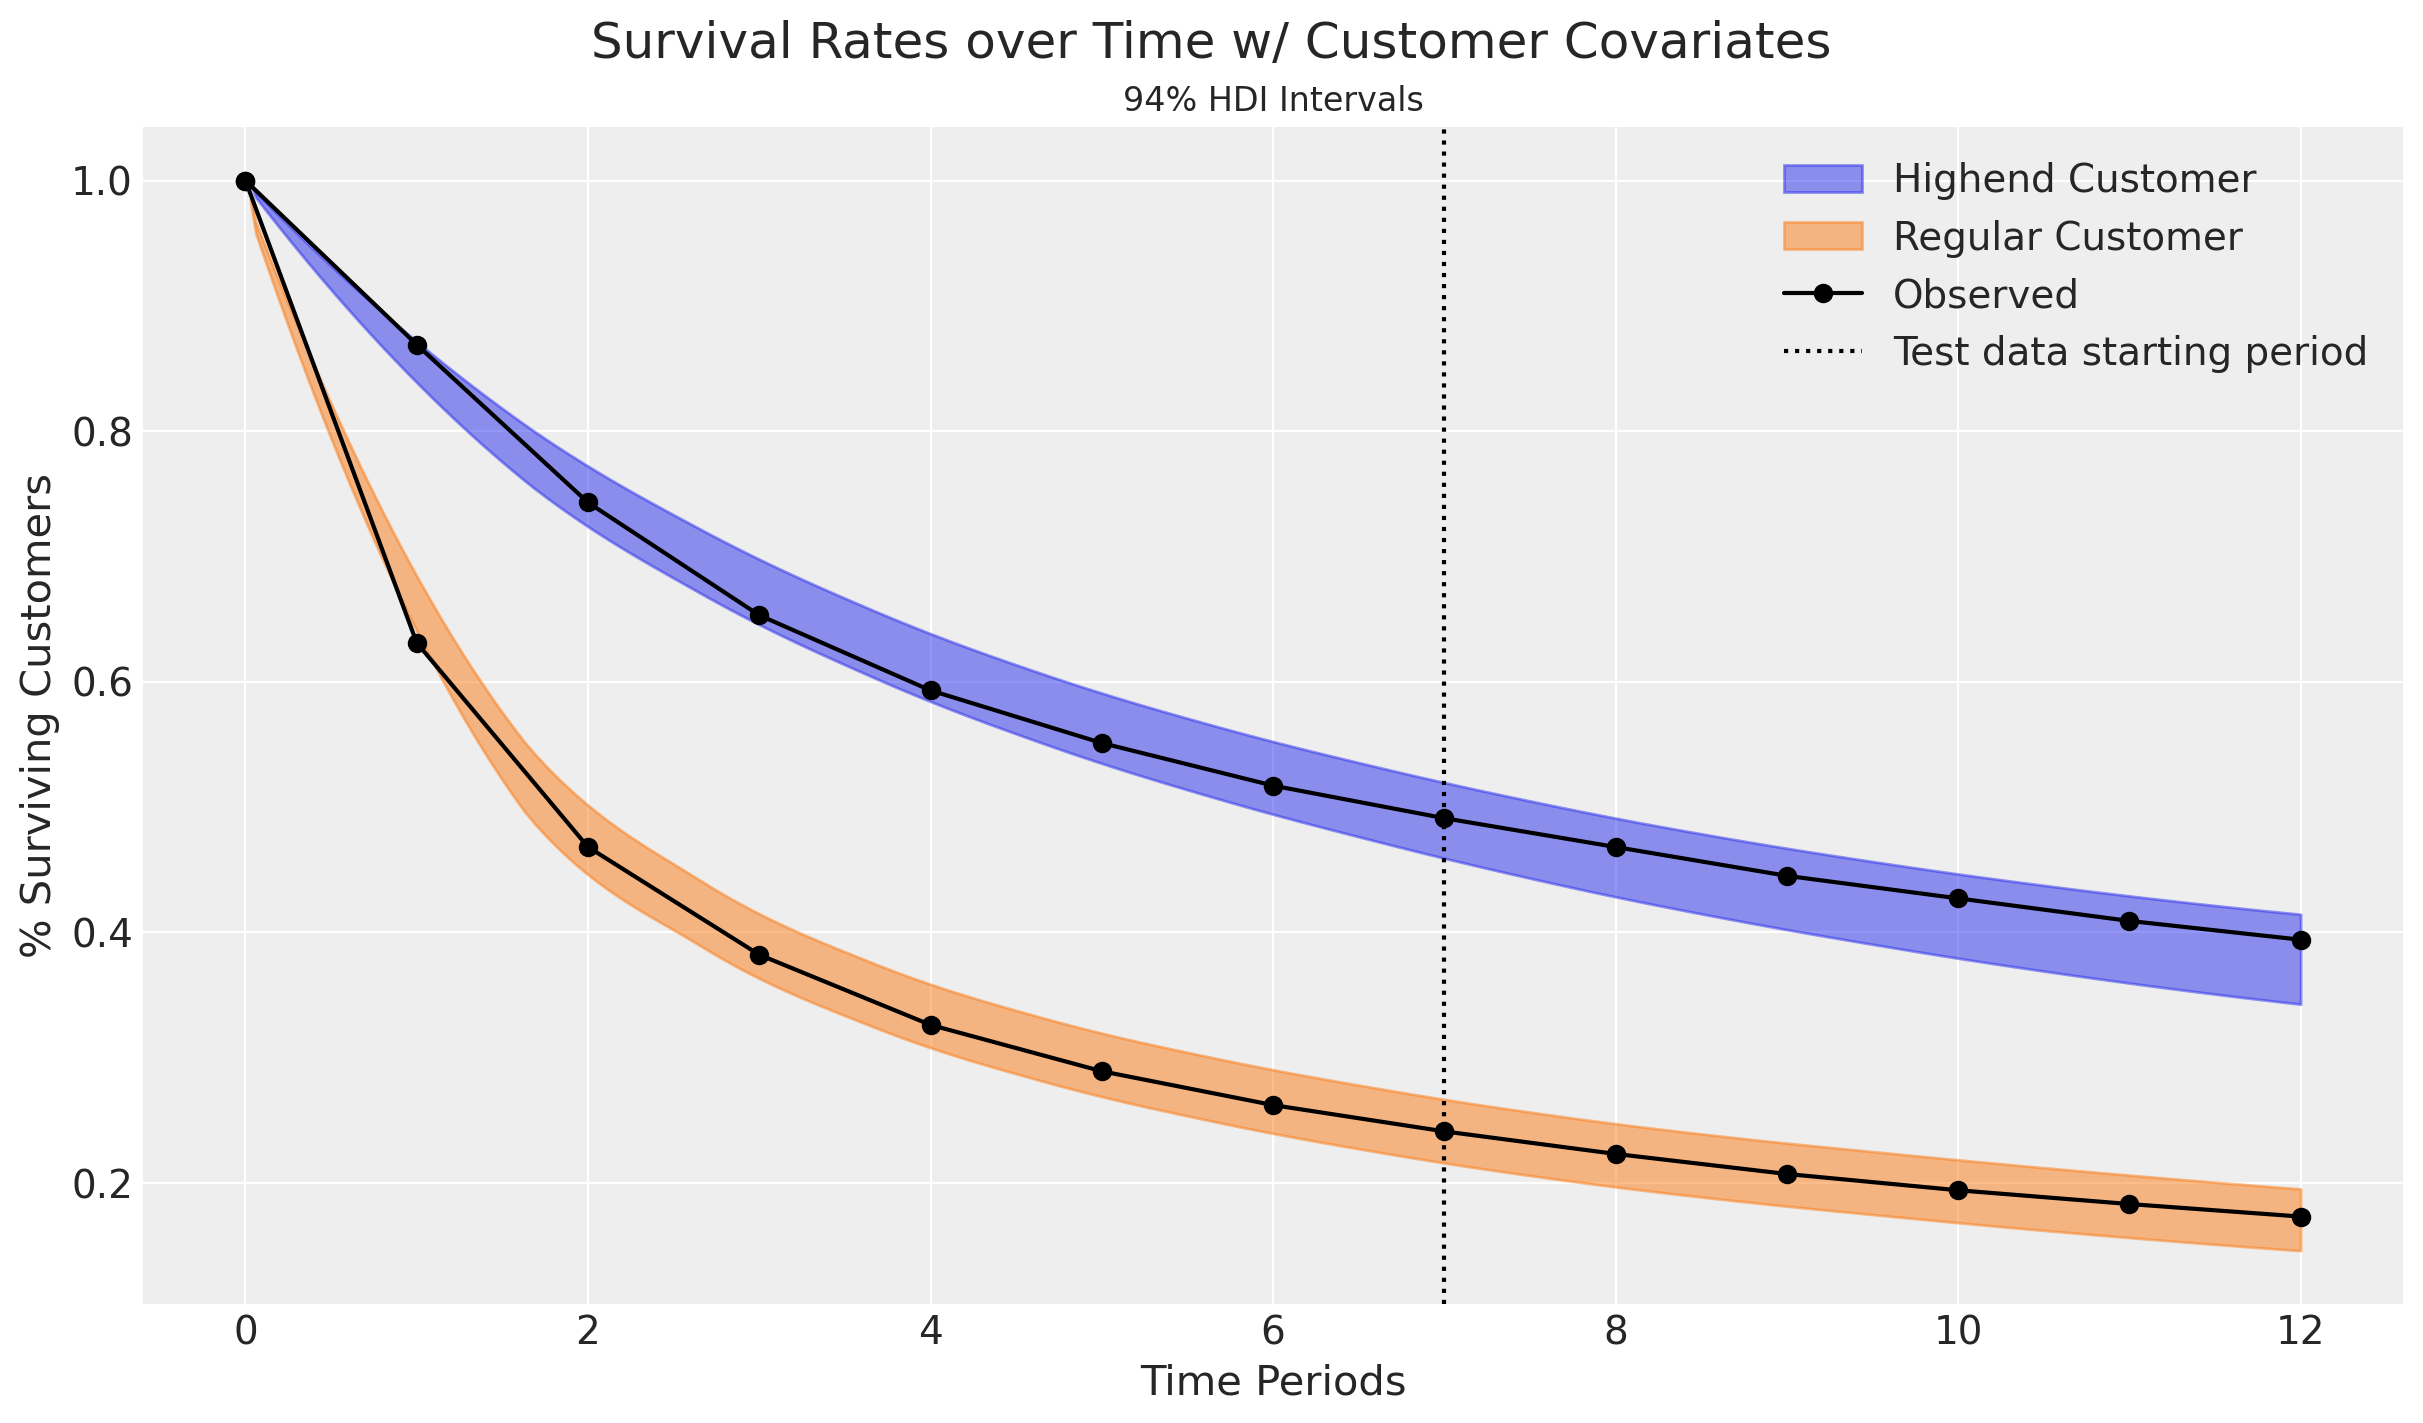

In [156]:
az.plot_hdi(
        range(test_T),
        expected_survival_rates_hi.mean("cohort"),
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.5, "label": "Highend Customer"},
    )
az.plot_hdi(
        range(test_T),
        expected_survival_rates_reg.mean("cohort"),
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.5, "label": "Regular Customer"},
    )

plt.plot(range(test_T), research_data["highend"]/100, marker='o', color="k", label="Observed")
plt.plot(range(test_T), research_data["regular"]/100, marker='o', color="k")
plt.ylabel("% Surviving Customers")
plt.xlabel("Time Periods")
plt.axvline(7, ls=":", color="k", label="Test data starting period")
plt.legend()
plt.suptitle("Survival Rates over Time w/ Customer Covariates",fontsize=18)
plt.title("94% HDI Intervals",fontsize=12);

# End-to-End Example with Cohorts and Covariates

Let's expand the previous covariate dataframe to create a cohort dataset which also includes covariates. We will create 7 monthly cohorts and withhold 5 periods for testing:

In [161]:
# Use covariate_df to generate 7 monthly cohorts
cohort_dfs = []

for month in range(1, 8):
    # Calculate observation period: January (month 1) has 8 periods, July (month 7) has 2 periods
    observation_periods = 9 - month  # 8 for month 1, 7 for month 2, ..., 2 for month 7
    month_cohort_name = f"2025-{month:02d}"
    
    # Copy the covariate data
    monthly_cohort_df = covariate_df.copy()
    
    # Truncate recency to the observation period
    # If a customer churned after the observation period, they appear alive at T
    monthly_cohort_df["recency"] = monthly_cohort_df["recency"].clip(upper=observation_periods)
    
    # Update T to the correct observation period for this cohort
    monthly_cohort_df["T"] = observation_periods
    
    # Add the time-based cohort (month they joined)
    monthly_cohort_df["cohort"] = month_cohort_name
    
    cohort_dfs.append(monthly_cohort_df)

# Combine all monthly cohorts
monthly_cohort_dataset = pd.concat(cohort_dfs, ignore_index=True)

# Recreate customer_id to be unique across all cohorts
monthly_cohort_dataset["customer_id"] = monthly_cohort_dataset.index + 1

# Reorder columns
monthly_cohort_dataset = monthly_cohort_dataset[[
    'customer_id', 'recency', 'T', 'cohort', 'highend_customer', 
]]

print(f"\nMonthly cohorts: {sorted(monthly_cohort_dataset['cohort'].unique())}")


Monthly cohorts: ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07']


In [218]:
monthly_cohort_dataset

customer_id  recency  T   cohort  highend_customer
0                1        1  8  2025-01                 1
1                2        1  8  2025-01                 1
2                3        1  8  2025-01                 1
3                4        1  8  2025-01                 1
4                5        1  8  2025-01                 1
...            ...      ... ..      ...               ...
13995        13996        2  2  2025-07                 0
13996        13997        2  2  2025-07                 0
13997        13998        2  2  2025-07                 0
13998        13999        2  2  2025-07                 0
13999        14000        2  2  2025-07                 0

[14000 rows x 5 columns]

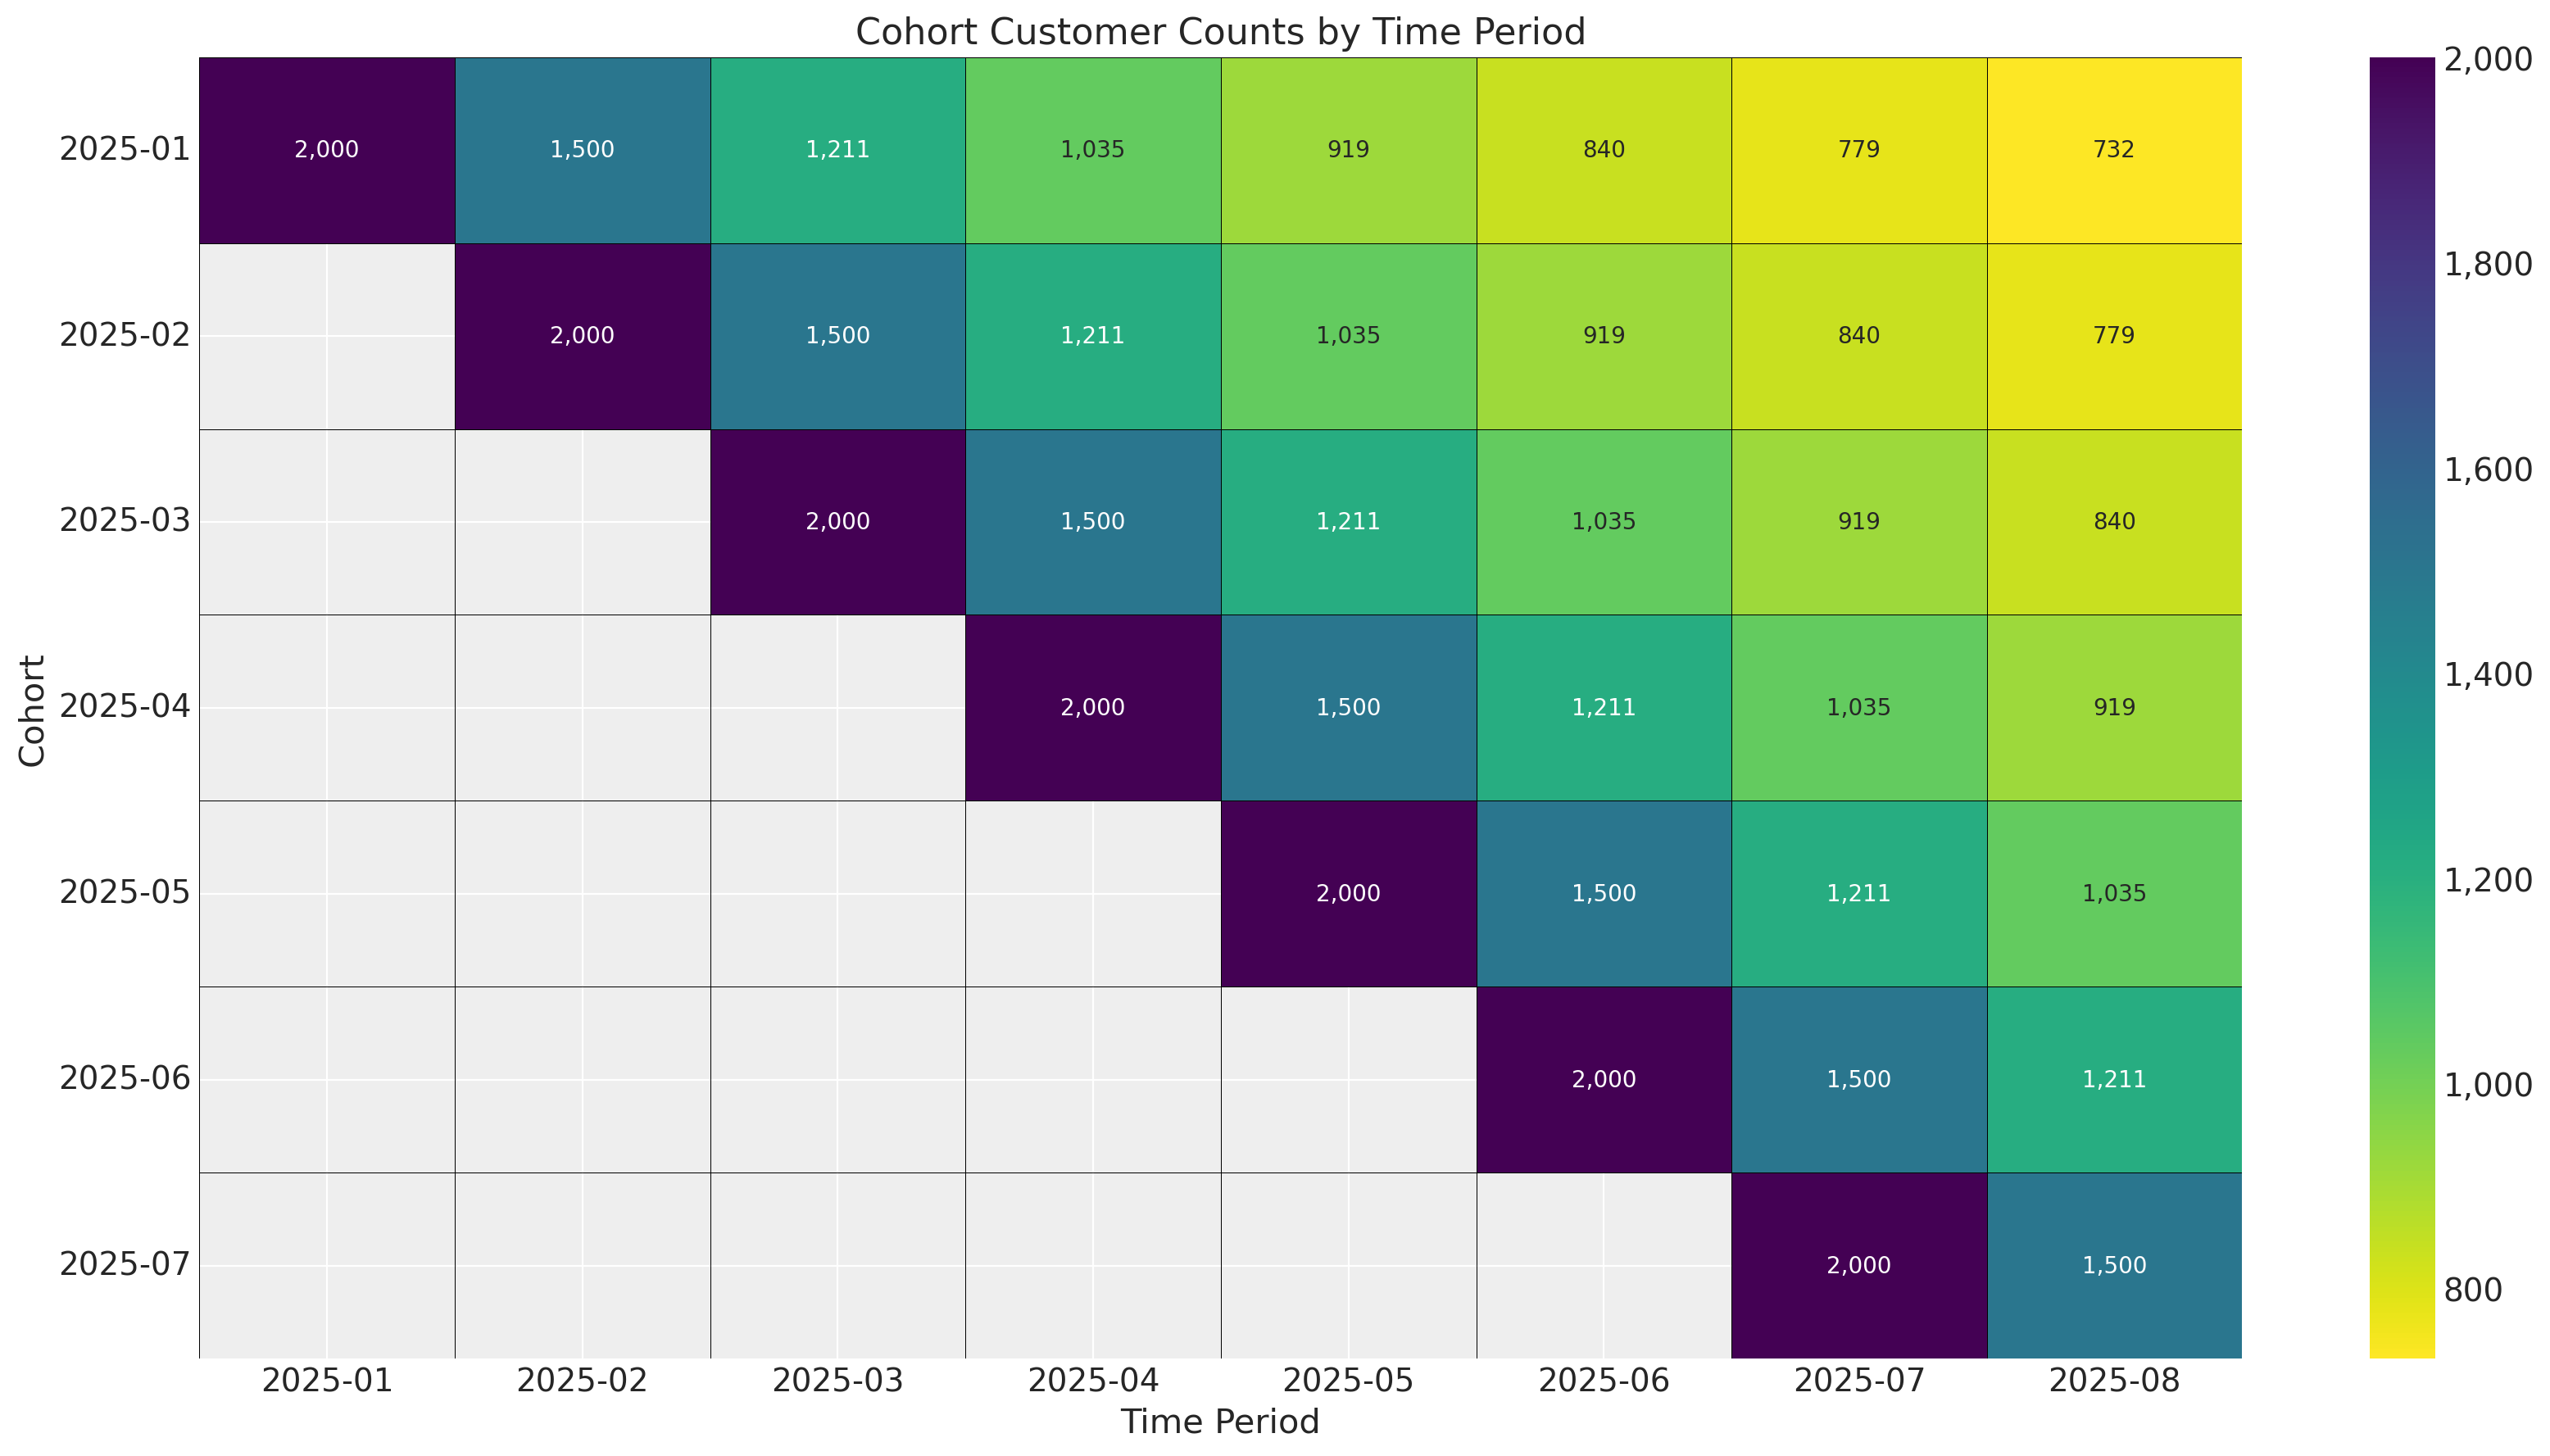

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta

def pivot_sbg_cohort_data(customer_df: pd.DataFrame) -> pd.DataFrame:
    """
    Transform ShiftedBetaGeoModel modeling data into an upper triangular cohort chart 
    with labeled time periods.
    
    Parameters
    ----------
    customer_df : pd.DataFrame
        DataFrame with columns: customer_id, recency, T, cohort
        Cohort should be in YYYY-MM format
        
    Returns
    -------
    pd.DataFrame
        Pivoted DataFrame with cohorts as index, calendar periods as columns
    """
    results = []
    
    for cohort in customer_df['cohort'].unique():
        cohort_df = customer_df[customer_df['cohort'] == cohort]
        total_customers = len(cohort_df)
        max_t_cohort = cohort_df['T'].iloc[0]
        
        # Parse cohort date
        cohort_date = pd.to_datetime(cohort)
        
        # Calculate retention for each relative period (age)
        for age in range(max_t_cohort):      
            # Calculate absolute calendar period (cohort_date + age months)
            period = cohort_date + relativedelta(months=age)
            period_str = period.strftime('%Y-%m')
            
            # Calculate number of surviving customers
            survived = (cohort_df['recency'] > age).sum().astype(np.int64)
            
            results.append({
                'cohort': cohort,
                'period': period_str,
                'cohort_age': age,
                'retention': survived
            })
    
    # Pivot to get cohorts as rows, calendar periods as columns
    pivot_df = pd.DataFrame(results).pivot(
        index='cohort',
        columns='period',
        values='retention'
    )
    
    # Sort index (cohorts) and columns (periods) chronologically
    pivot_df = pivot_df.sort_index()
    pivot_df = pivot_df[sorted(pivot_df.columns)]
    
    return pivot_df


# Create pivoted data
cohort_pivot = pivot_sbg_cohort_data(monthly_cohort_dataset)

plt.rcParams['figure.constrained_layout.use'] = False

# Plot cohort chart as a heatmap
fig, ax = plt.subplots(figsize=(17, 9))

sns.heatmap(
    cohort_pivot,
    cmap='viridis_r',
    linewidths=0.2,
    linecolor='black',
    annot=True,
    fmt=",.0f",
    cbar_kws={'format': mtick.FuncFormatter(func=lambda y, _: f'{y:,.0f}')},
    ax=ax,
)

# Rotate y-axis labels to horizontal
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

ax.set_title('Cohort Customer Counts by Time Period')
ax.set_ylabel('Cohort')
ax.set_xlabel('Time Period')

plt.tight_layout()
plt.show()

Add write-up here about seasonality; wrap below code into a function and move to top of notebook

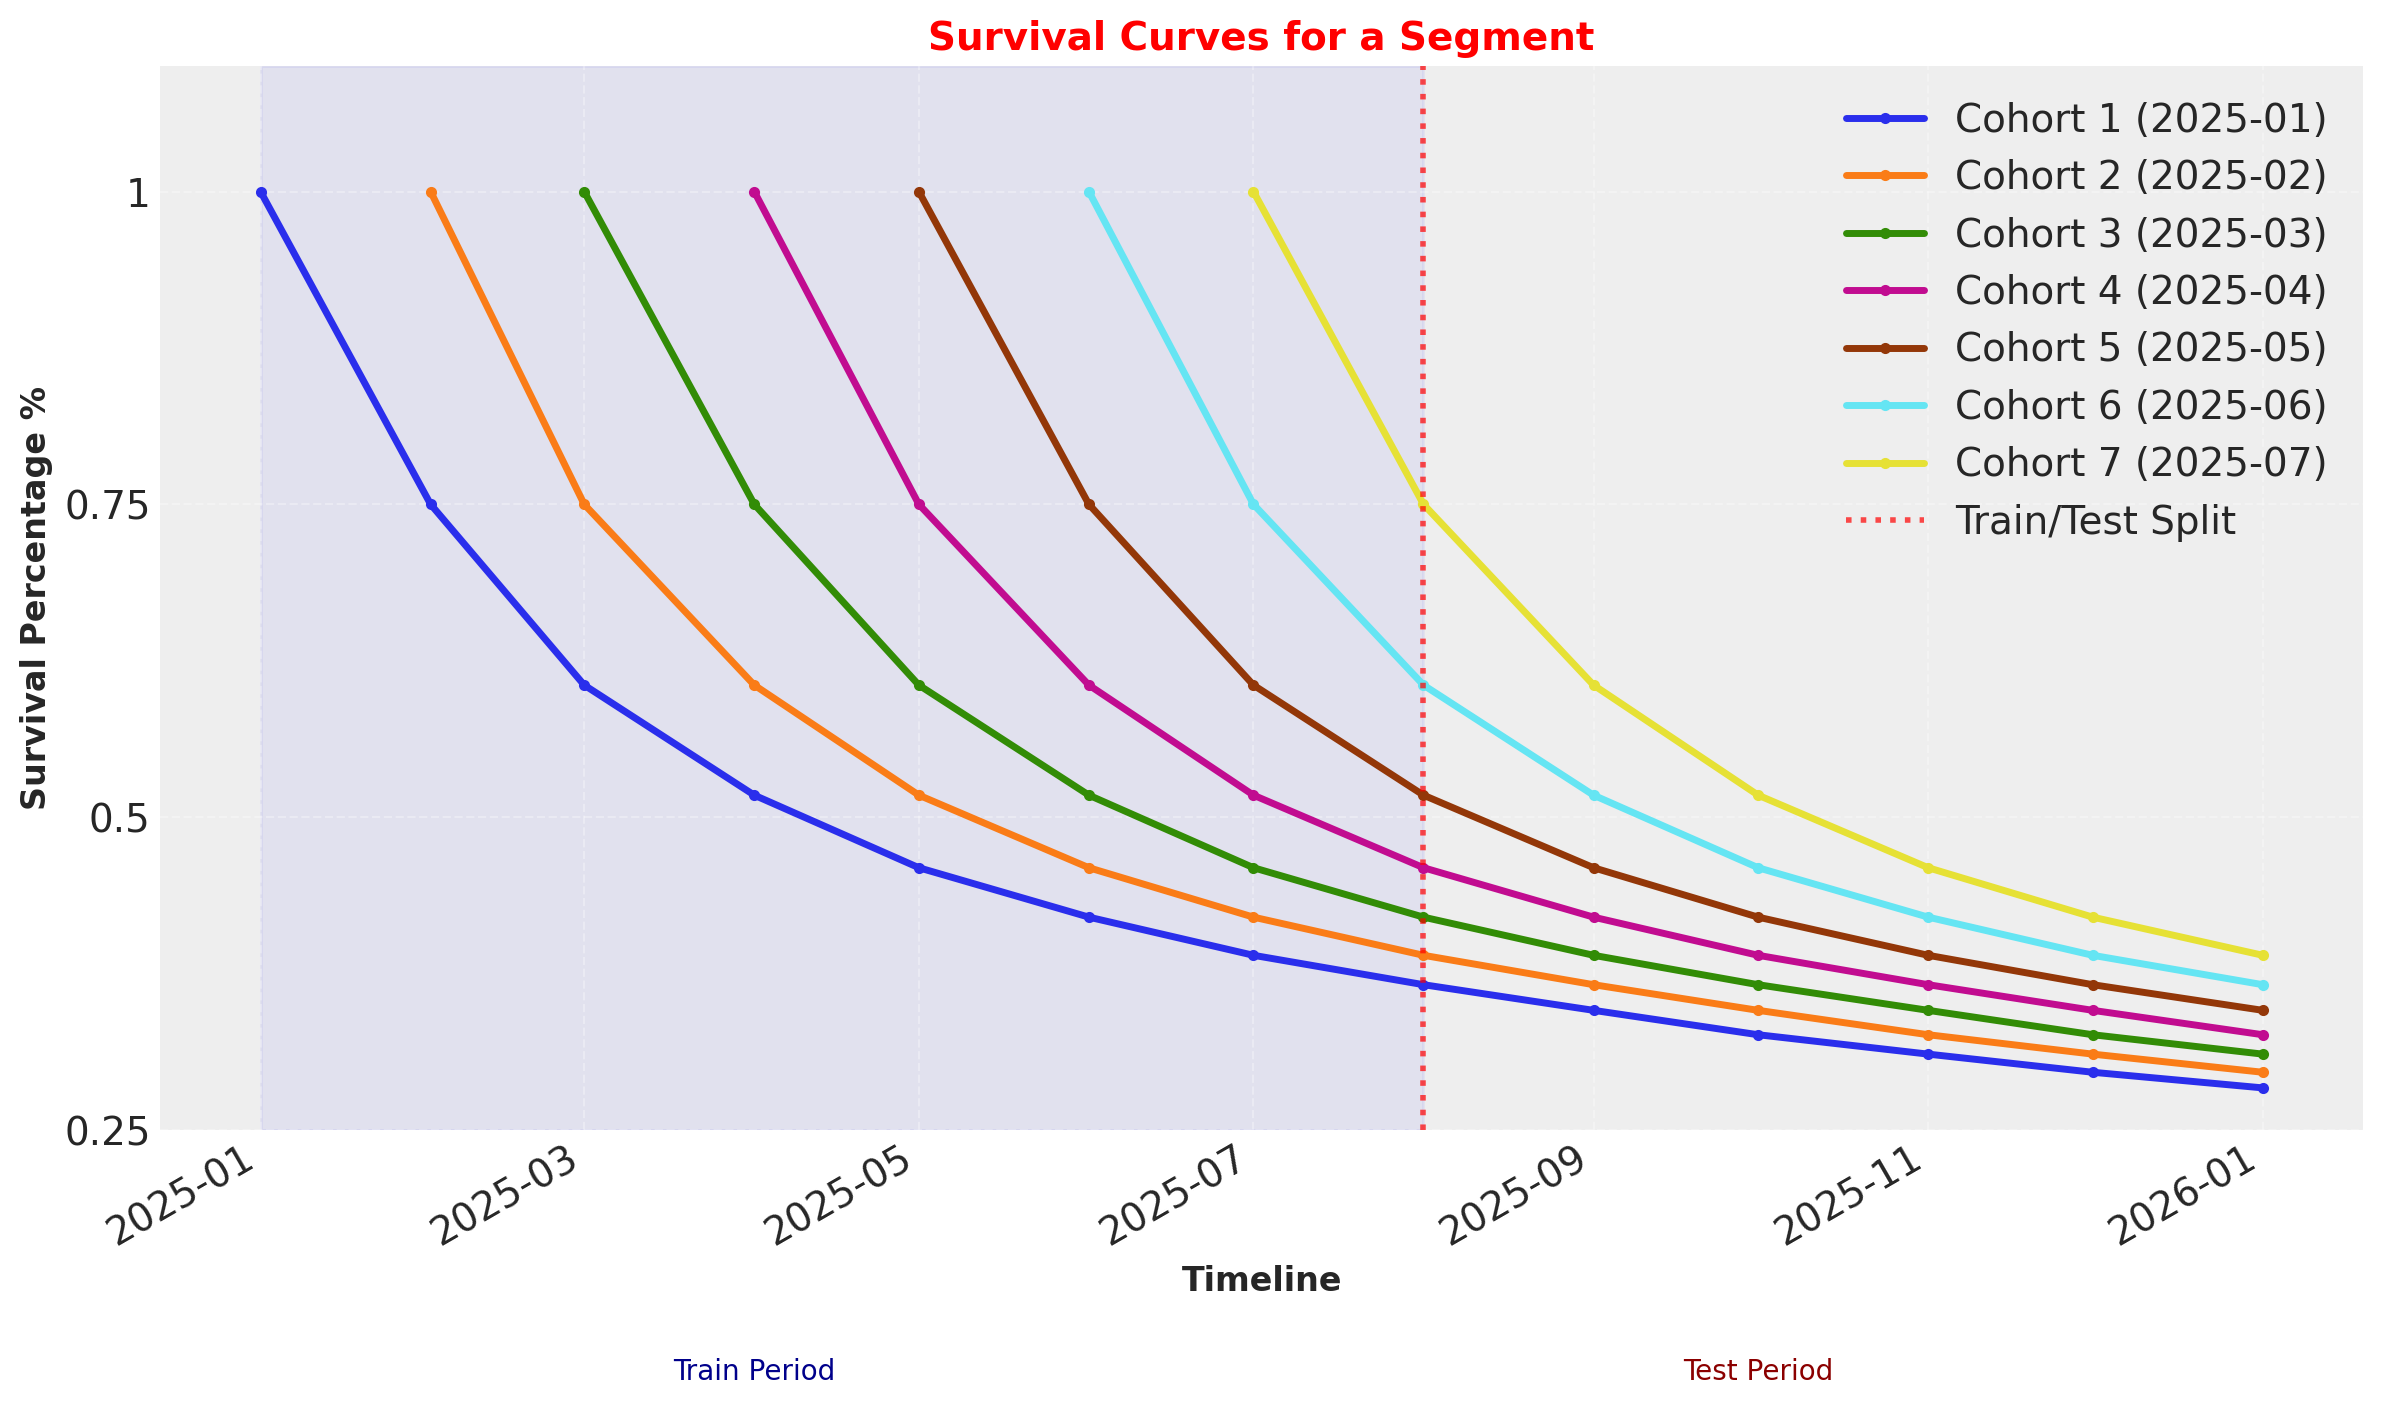

In [168]:
# Base survival curve (same pattern for all cohorts)
base_survival = research_data[["regular","highend"]].values.mean(axis=1)/100

# Create figure
fig, ax = plt.subplots(figsize=(12, 7))

# Define cohort start dates
cohort_start_dates = sorted(monthly_cohort_dataset['cohort'].unique())

# Plot each cohort
for i, cohort_date in enumerate(cohort_start_dates):
    # Calculate how many periods this cohort has been observed
    # Later cohorts have fewer observed periods
    observed_periods = len(base_survival) - i
    
    # Get survival data for this cohort
    cohort_survival = base_survival[:observed_periods]
    
    # Create timeline for this cohort (absolute dates)
    cohort_start = pd.to_datetime(cohort_date)
    cohort_timeline = [cohort_start + relativedelta(months=j) for j in range(observed_periods)]
    
    # Plot the survival curve
    ax.plot(cohort_timeline, cohort_survival, 
            linewidth=2.5, 
            marker='o', 
            markersize=3,
            label=f'Cohort {i+1} ({cohort_date})')

# Add vertical line separating train/test periods
train_end_date = pd.to_datetime('2025-08')
ax.axvline(train_end_date, 
           linestyle=':', 
           color='red', 
           linewidth=2, 
           alpha=0.7,
           label='Train/Test Split')

# Add shaded regions for train and test periods
ax.axvspan(pd.to_datetime('2025-01'), train_end_date, 
           alpha=0.05, color='blue', zorder=0)
ax.text(pd.to_datetime('2025-04'), 0.05, 'Train Period', 
        ha='center', fontsize=10, color='darkblue')

# Add test period label
test_end_date = pd.to_datetime('2026-06')
ax.text(pd.to_datetime('2025-10'), 0.05, 'Test Period', 
        ha='center', fontsize=10, color='darkred')

# Formatting
ax.set_xlabel('Timeline', fontsize=12, fontweight='bold')
ax.set_ylabel('Survival Percentage %', fontsize=12, fontweight='bold')
ax.set_title('Survival Curves for a Segment', fontsize=14, fontweight='bold', color='red')

# Set y-axis limits
ax.set_ylim(0.25, 1.1)

# Format y-axis as percentage
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0.25', '0.5', '0.75', '1'])

# Format x-axis dates
ax.tick_params(axis='x', rotation=45)
fig.autofmt_xdate()

# Add legend
ax.legend(loc='upper right', framealpha=0.9)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### Cohort Model Fitting

`DEMEtropolisZ` is not recommended in this scenario because although it works well for covariates, covergence is more difficult when dealing with multiple cohorts. For large datasets with millions of customers and dozens of cohorts, MAP fits may be the most practical option.

Regardless of the fit method, multidimensional models in general require well-defined priors - priors that are too broad may diverge, and if too narrow can overfit. For more information on specifying priors see the [Prior Configuration](https://www.pymc-marketing.io/en/stable/notebooks/general/model_configuration.html#prior-distributions) section of the Model Configuration Notebook.

For the remainder of this notebook we will be using the default model config with the external NUTS `nutpie` sampler, which is written in *rust* and can run on GPUs.

In [247]:
sbg_cohort = clv.ShiftedBetaGeoModel(
    data=monthly_cohort_dataset,
        model_config = {
        "dropout_covariate_cols": ["highend_customer"],
    }
)
sbg_cohort.fit(method='mcmc',nuts_sampler="nutpie",random_seed=rng)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

Warmup iterations saved (warmup_*).

In [165]:
sbg_cohort.fit_summary(var_names=["alpha_scale","beta_scale", "dropout_coefficient_alpha", "dropout_coefficient_beta"])

mean      sd  hdi_3%  hdi_97%  \
alpha_scale[2025-01]                         0.672   0.058   0.567    0.780   
alpha_scale[2025-02]                         0.700   0.065   0.582    0.826   
alpha_scale[2025-03]                         0.739   0.074   0.612    0.884   
alpha_scale[2025-04]                         0.796   0.096   0.619    0.968   
alpha_scale[2025-05]                         0.861   0.136   0.625    1.117   
alpha_scale[2025-06]                         1.002   0.289   0.587    1.525   
alpha_scale[2025-07]                         2.916  16.714   0.339    5.822   
beta_scale[2025-01]                          1.130   0.131   0.888    1.368   
beta_scale[2025-02]                          1.179   0.146   0.914    1.453   
beta_scale[2025-03]                          1.249   0.161   0.967    1.559   
beta_scale[2025-04]                          1.348   0.203   0.974    1.712   
beta_scale[2025-05]                          1.462   0.274   1.013    2.003   
beta_scale[2025-06]                          1.731   0.553   0.917    2.702   
beta_scale[2025-07]                          5.188  29.984   0.621   10.168   
dropout_coefficient_alpha[highend_customer] -0.160   0.111  -0.368    0.048   
dropout_coefficient_beta[highend_customer]  -1.412   0.132  -1.683   -1.186   

                                             mcse_mean  mcse_sd  ess_bulk  \
alpha_scale[2025-01]                             0.001    0.001    3867.0   
alpha_scale[2025-02]                             0.001    0.001    4014.0   
alpha_scale[2025-03]                             0.001    0.001    3220.0   
alpha_scale[2025-04]                             0.001    0.002    4537.0   
alpha_scale[2025-05]                             0.002    0.002    4429.0   
alpha_scale[2025-06]                             0.004    0.008    5155.0   
alpha_scale[2025-07]                             0.353    3.257    5528.0   
beta_scale[2025-01]                              0.002    0.002    3507.0   
beta_scale[2025-02]                              0.002    0.002    3686.0   
beta_scale[2025-03]                              0.003    0.002    2978.0   
beta_scale[2025-04]                              0.003    0.003    3947.0   
beta_scale[2025-05]                              0.004    0.005    3976.0   
beta_scale[2025-06]                              0.009    0.016    4693.0   
beta_scale[2025-07]                              0.633    5.964    5481.0   
dropout_coefficient_alpha[highend_customer]      0.003    0.002    1105.0   
dropout_coefficient_beta[highend_customer]       0.004    0.003    1108.0   

                                             ess_tail  r_hat  
alpha_scale[2025-01]                           3197.0    1.0  
alpha_scale[2025-02]                           3284.0    1.0  
alpha_scale[2025-03]                           3112.0    1.0  
alpha_scale[2025-04]                           3201.0    1.0  
alpha_scale[2025-05]                           3244.0    1.0  
alpha_scale[2025-06]                           3060.0    1.0  
alpha_scale[2025-07]                           2581.0    1.0  
beta_scale[2025-01]                            2965.0    1.0  
beta_scale[2025-02]                            2892.0    1.0  
beta_scale[2025-03]                            2780.0    1.0  
beta_scale[2025-04]                            2872.0    1.0  
beta_scale[2025-05]                            2891.0    1.0  
beta_scale[2025-06]                            2967.0    1.0  
beta_scale[2025-07]                            2582.0    1.0  
dropout_coefficient_alpha[highend_customer]    1592.0    1.0  
dropout_coefficient_beta[highend_customer]     1590.0    1.0

We can see from the Fit summary that the highend customer covariate has similar affects to that of the previous, single cohort model, but the cohort parameters shift towards larger values (and higher dropout probabilities) in later cohorts as observable training data decreases - all cohorts have 2,000 customers, but 75% of these are right-censored the 2025-07 cohort compared to 38.8% in 2025-01.

Where multidimensional Bayesian models really shine is information-sharing for parameter estimation.

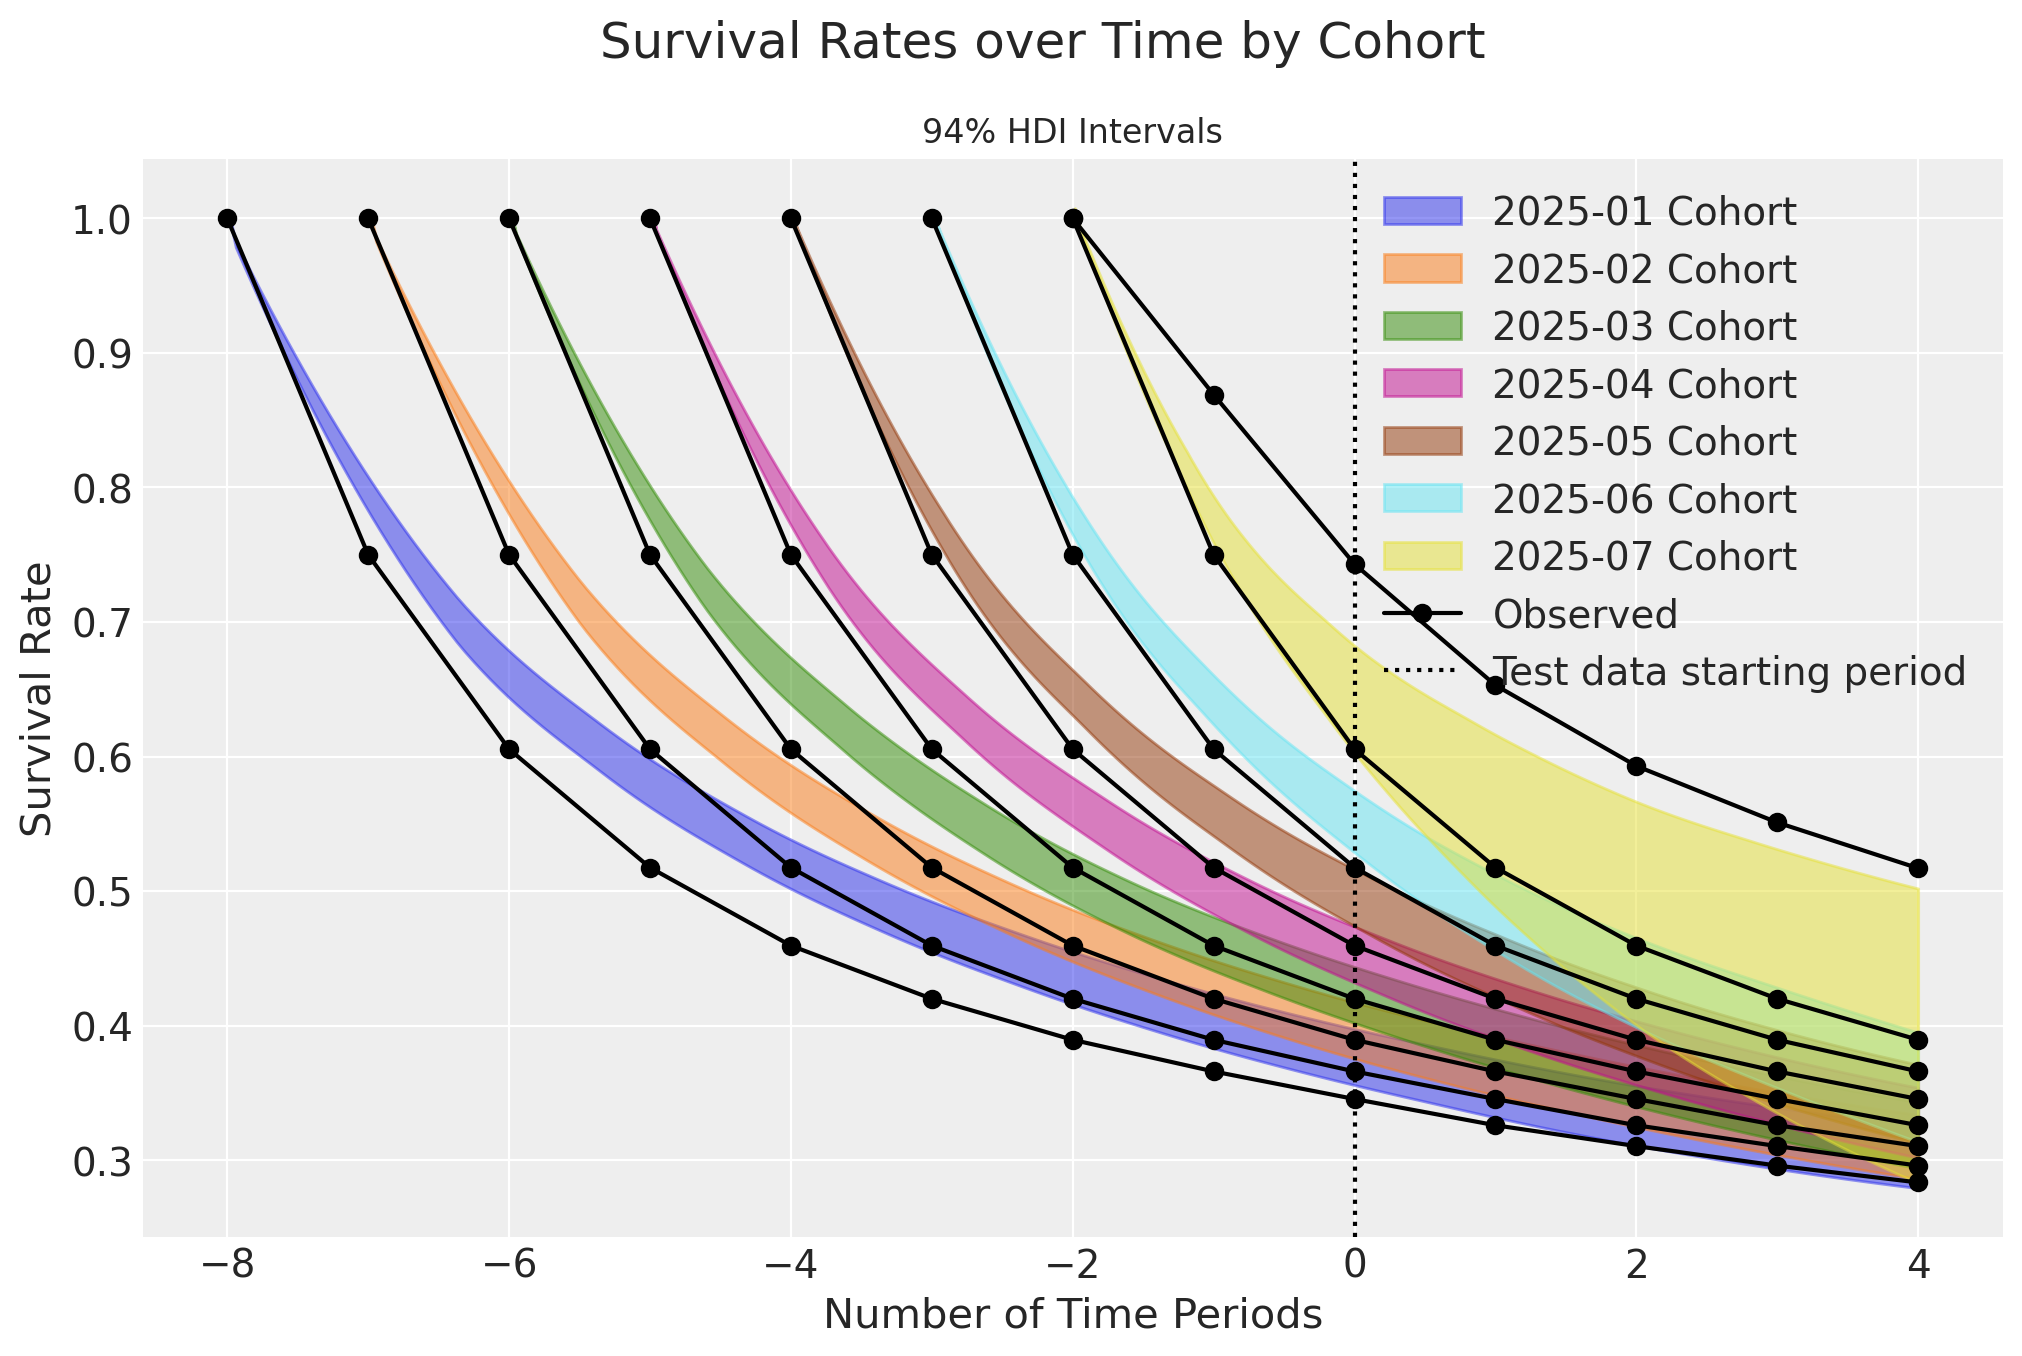

In [ ]:
all_T = len(base_survival)
base_survival = research_data[["regular","highend"]].values.mean(axis=1)/100

for i, month in enumerate(cohort_start_dates):

    train_offset = i - 8
    offset_range = range(train_offset, all_T - i + train_offset)

    # Run predictions
    # TODO: This iterator would run much faster if predictive data per cohort were provided.
    expected_survival_rates = xr.concat(
    objs=[
        sbg_cohort.expected_probability_alive(
            future_t=T,
        )
        for T in offset_range
    ],
    dim="T",
    ).transpose(..., "T")

    # Plot predictions per cohort
    az.plot_hdi(
        offset_range,
        expected_survival_rates.sel(cohort=month).mean("cohort"),
        hdi_prob=0.94,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.5, "label": f"{month} Cohort"},
    )
    # Plot observed survival curve, shifting T index for each cohort
    plt.plot(offset_range, base_survival[:all_T-i], marker='o',color="k")

# Plot the observed survival curve one more time to get a single label for the legend
plt.plot(RANGE, SURVIVAL[:all_T-i], marker='o',color="k", label="Observed")
plt.axvline(0, ls=":", color="k", label="Test data starting period")
plt.legend()

plt.ylabel("Survival Rate")
plt.xlabel("Number of Time Periods")
plt.suptitle("Survival Rates over Time by Cohort",fontsize=18)
plt.title("94% HDI Intervals",fontsize=12);

There is obvious bias in these survival curves, but let's not panic just yet. Before scrapping this model and trying diffent Priors, let's take a look at the retention rates.

### Retention Rate
 
Although survival rates give a good snapshot of model performance, retention rates for the current time period are more useful in practice because they give an indication of which cohorts and customers to prioritize with marketing efforts.

When we plot retention rates, an interesting story emerges:

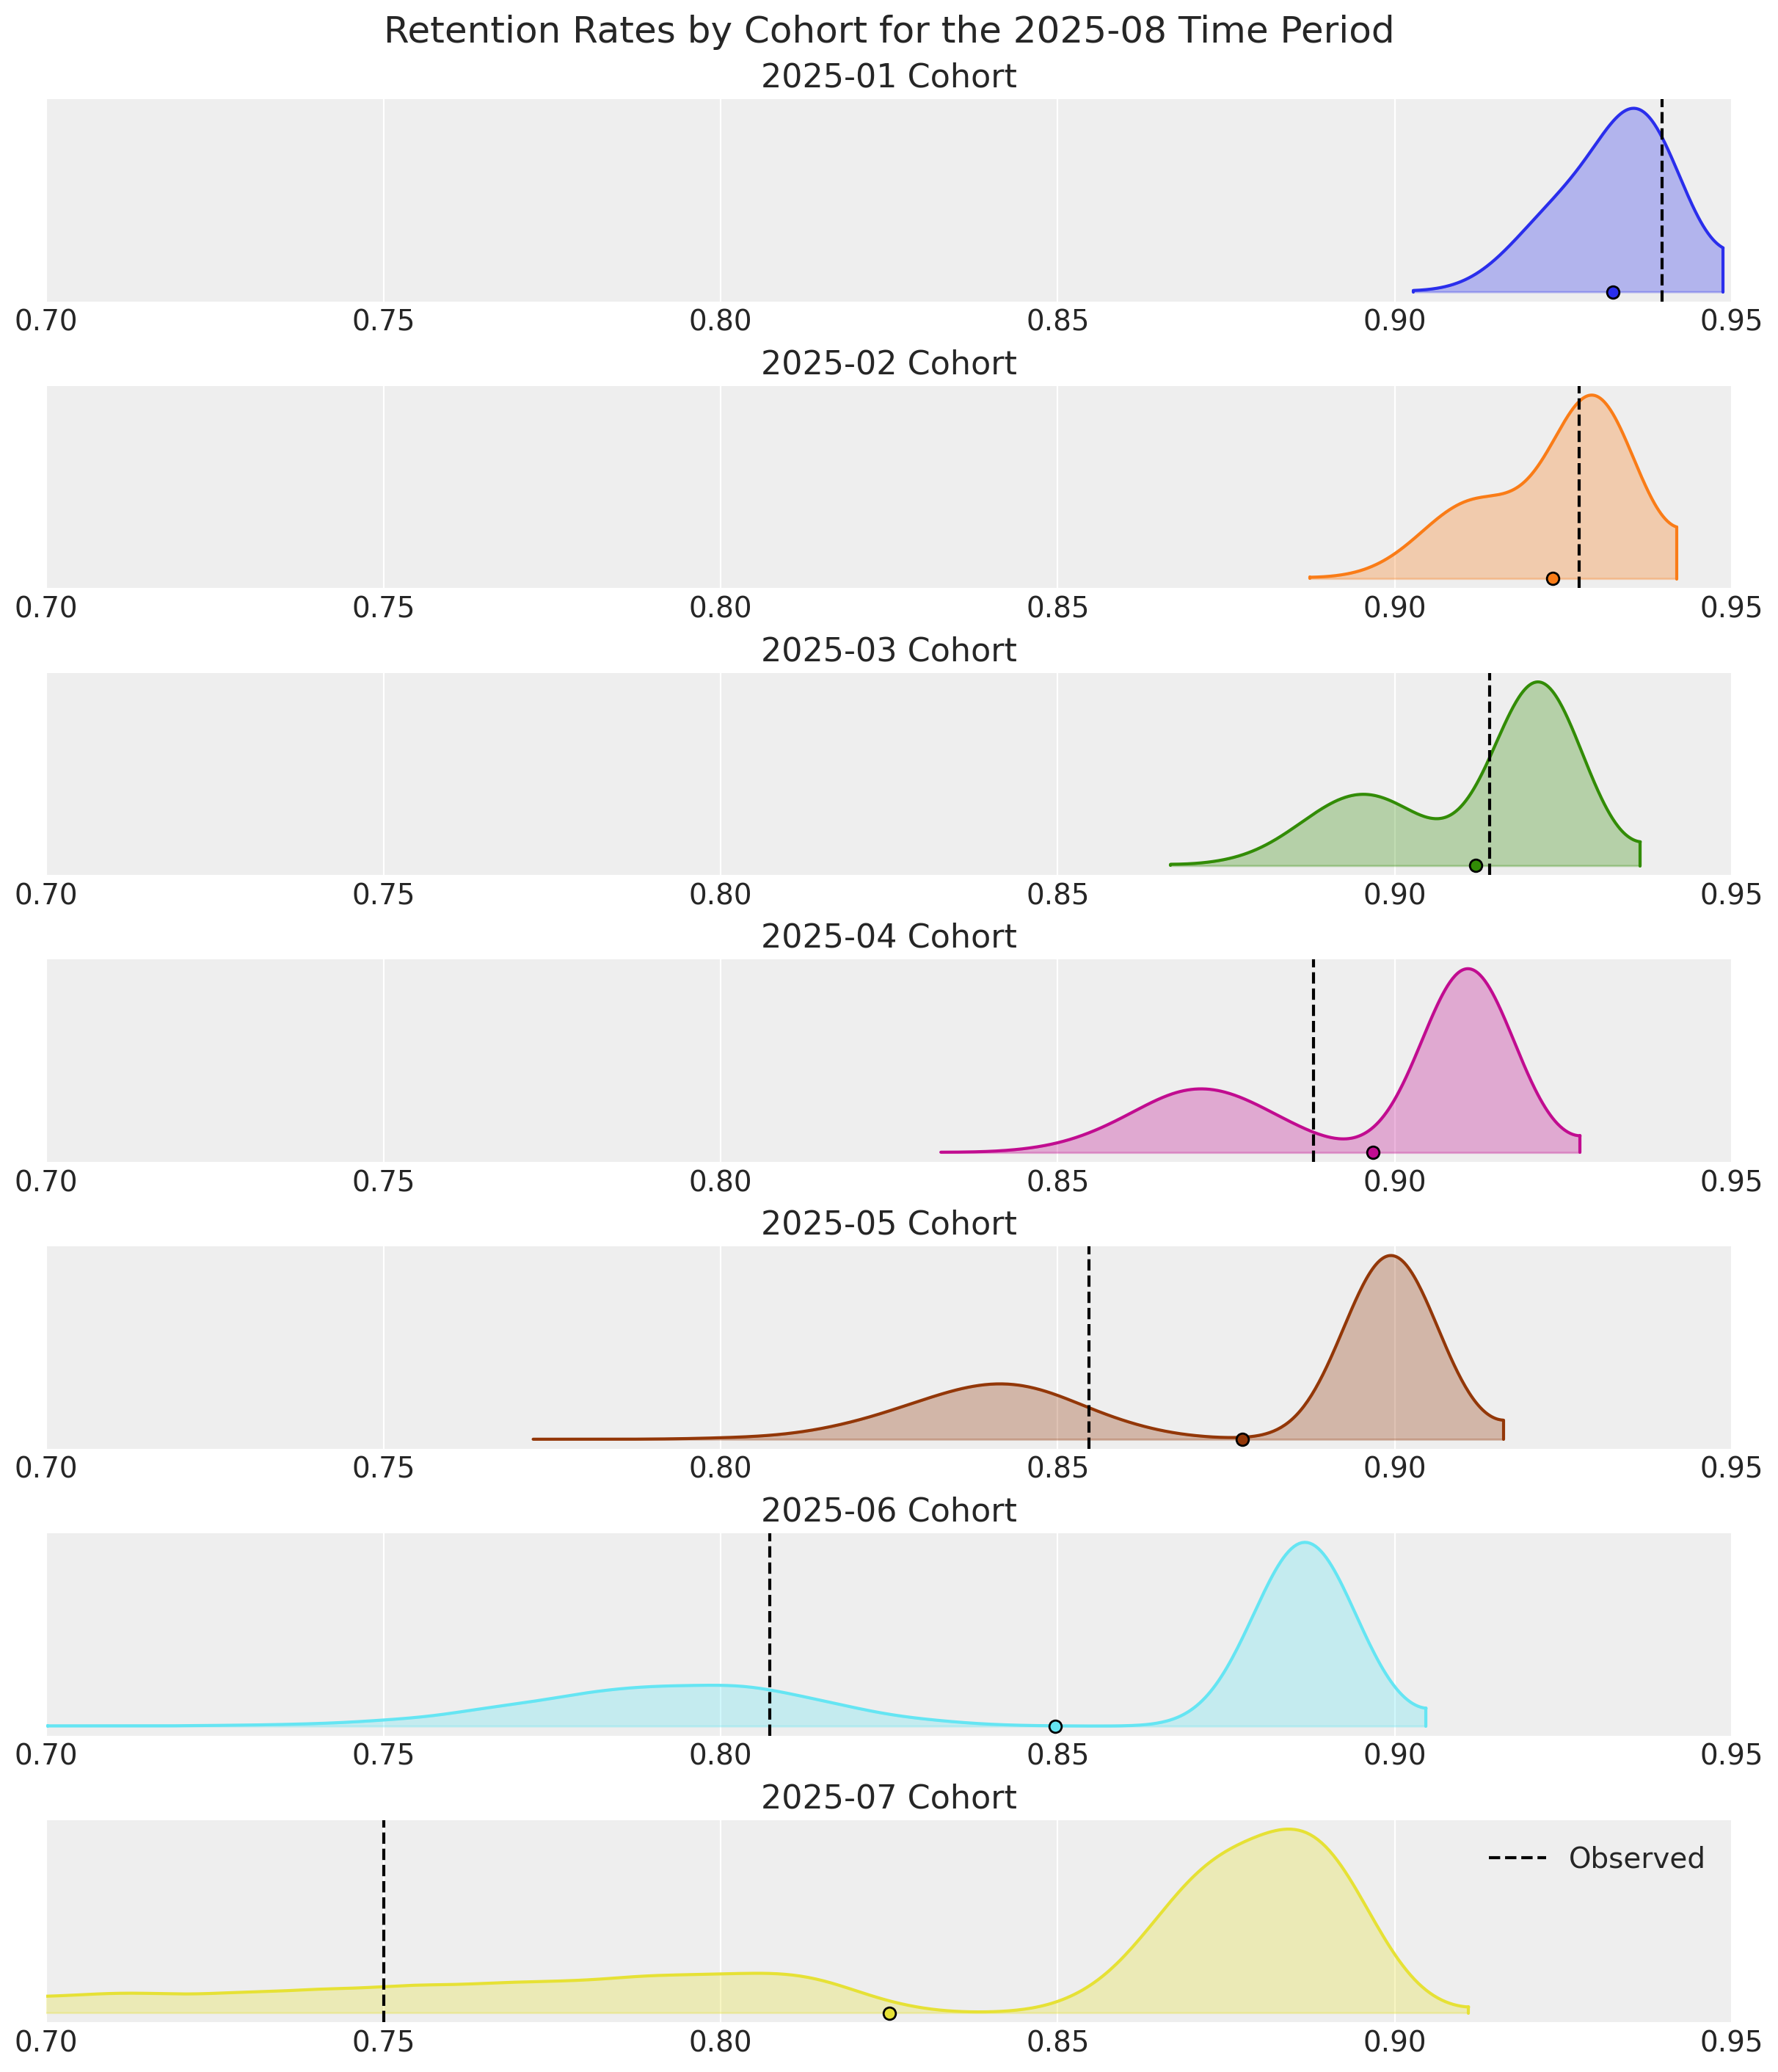

In [253]:
active_customers = monthly_cohort_dataset.query("recency==T").copy()
retention_rate_agg =  base_survival[1:] / base_survival[:-1]

_, axes = plt.subplots(
    nrows=7,
    ncols=1,
    figsize=(12, 14),
    layout="constrained",
)

axes = axes.flatten()

for i, month in enumerate(cohort_start_dates):
    ax = axes[i]
    active_monthly = active_customers[active_customers["cohort"]==month].copy()
    cohort_retention = sbg_cohort.expected_retention_rate(
            future_t=0,
        ).sel(cohort = month)

    az.plot_density(cohort_retention, hdi_prob=1, colors=f"C{i}", shade=0.3, bw=0.005, ax=ax)
    ax.axvline(x=retention_rate_agg[6-i], color="k",linestyle="--", label="Observed")
    ax.set(
        title=f"{month} Cohort",
        xlim=[0.70,0.95],
    )
plt.legend()
plt.gcf().suptitle("Retention Rates by Cohort for the 2025-08 Time Period",fontsize=18);

**Retention estimates are increasingly bi-modal for more recent cohorts!** Earlier cohorts have *a higher proportion of Highend customers in later time periods who biasing retention and survival estimates*. Observed retention rates shift towards Regular customers for later cohorts with fewer time period observations, reflecting higher proportions of Regular customers who cancel their contracts sooner.

For the record, if this model is refit to the same dataset sans covariates, the survival curves are spot-on, but the unimodal retention estimates provide no insight into why the observed rates drift further into the tail regions. This is why customer heterogeneity is a critical modeling consideration, and why **both retention and survival rates should be inspected after model fitting!** *When segmenting customers by discrete covariates, plot survival curves separately for each segment.*

## Discounted Residual Lifetime and Retention Elasticity
These additional predictive methods were introduced in the follow-up research paper ["Customer Base Valuation in a Contractual Setting: The Perils of Ignoring Heterogeneity"](https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf) by Hardie & Fader in 2010.

In [60]:
# filter dataset to only active customers
pred_data=dataset.query("recency==T")

# predict retention rate and convert to dataframe for downstream processing
pred_cohort_retention = sbg.expected_retention_rate(pred_data,future_t=0).mean(("chain","draw"))
pred_cohort_retention.to_dataframe(name="retention").reset_index()

cohort  customer_id  retention
0    highend          510   0.942107
1    highend          511   0.942107
2    highend          512   0.942107
3    highend          513   0.942107
4    highend          514   0.942107
..       ...          ...        ...
727  regular         1996   0.920621
728  regular         1997   0.920621
729  regular         1998   0.920621
730  regular         1999   0.920621
731  regular         2000   0.920621

[732 rows x 3 columns]

In [246]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Sun Nov 30 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pymc    : 5.25.1
pytensor: 2.31.7

pymc_extras   : 0.4.0
seaborn       : 0.13.2
xarray        : 2025.7.1
pytensor      : 2.31.7
dateutil      : 2.9.0.post0
matplotlib    : 3.10.3
numpy         : 2.2.6
pymc_marketing: 0.17.0
pymc          : 5.25.1
arviz         : 0.22.0
pandas        : 2.3.1

Watermark: 2.5.0

